In [1]:
# Files in data/ must be downloaded from https://doi.org/10.5281/zenodo.10932490
graph_A:str = 'data/pggb_vs_mgc/15_yeast_mgc_CASBJU01_chr_1.gfa'
graph_B:str = 'data/pggb_vs_mgc/15_yeast_pggb_chr_1.gfa'
# Files in temp/* will be created during the execution of the notebook
edition_file: str = 'temp/yeast_edit.json'
reference:list[str] = ['CASBJU01']
chromosom:str = '1'
node_class_sizes:list[tuple] = [
    (0,1),
    (2,9),
    (10,49),
    (50,float('inf'))
]

In [2]:
# Colorblind-friendly palette
colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
}

In [3]:
from json import load
from matplotlib import pyplot as plt
from pgGraphs import Graph
from os import system
from seaborn import regplot, violinplot, clustermap
from pandas import DataFrame
from scipy import stats
from collections import Counter
from statistics import mean,stdev,median
from numpy import arange
from subprocess import run,PIPE
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from random import choice, choices, randint,seed
from tharospytools.matplotlib_tools import get_palette_from_list

# Création des fichiers pour la comparaison des graphes

In [4]:
# First, we compute edition to be sure to have a list of breakpoints
system(f'pancat edit {graph_A} {graph_B} -o {edition_file}')

[07/30/2024 11:34:38 AM] Loaded graph data/pggb_vs_mgc/15_yeast_mgc_CASBJU01_chr_1.gfa in memory
Paths of Graph_A CASBIT01, CASBIW01, CASBIZ01, CASBJG01, CASBJH01, CASBJI01, CASBJJ01, CASBJL01, CASBJM01, CASBJN01, CASBJQ01, CASBJS01, CASBJT01, CASBJU01, CASBJV01
[07/30/2024 11:34:39 AM] Loaded graph data/pggb_vs_mgc/15_yeast_pggb_chr_1.gfa in memory
Paths of Graph_B CASBIT01, CASBIW01, CASBIZ01, CASBJG01, CASBJH01, CASBJI01, CASBJJ01, CASBJL01, CASBJM01, CASBJN01, CASBJQ01, CASBJS01, CASBJT01, CASBJU01, CASBJV01
[07/30/2024 11:34:39 AM] Computing edition for graphs on single thread
PATH SELECTION: {'CASBJH01', 'CASBIT01', 'CASBJS01', 'CASBJI01', 'CASBJL01', 'CASBJJ01', 'CASBJG01', 'CASBJV01', 'CASBJN01', 'CASBJQ01', 'CASBJU01', 'CASBIW01', 'CASBIZ01', 'CASBJT01', 'CASBJM01'}
[07/30/2024 11:34:39 AM] Saving results in temp/yeast_edit.json
[07/30/2024 11:34:40 AM] Job terminated sucessfully!
func:'perform_edition' args:[(), {'gfa_A': 'data/pggb_vs_mgc/15_yeast_mgc_CASBJU01_chr_1.gfa', 'g

0

# Chargement en mémoire

In [5]:
editions:dict[str,list] = load(open(edition_file,'r',encoding='utf-8'))

cactus_gfa:Graph = Graph(graph_A)
pggb_gfa:Graph = Graph(graph_B)

On calcule les tags de position pour avoir nos repères dans les deux graphes.

In [6]:
cactus_gfa.sequence_offsets()
pggb_gfa.sequence_offsets()

# Métriques sur les graphes

In [7]:
# Affichage des tailles de chemins, tailles des noeuds
graph_A_node_sizes: dict[str,int] = {node_name:node_datas['length'] for node_name,node_datas in cactus_gfa.segments.items()}
graph_B_node_sizes: dict[str,int] = {node_name:node_datas['length'] for node_name,node_datas in pggb_gfa.segments.items()}

In [8]:
# Calcul des classes de taille de noeuds
node_A_class_sizes: list[int] = [0 for _ in node_class_sizes] # nb de noeuds
node_A_class_lengths: list[int] = [0 for _ in node_class_sizes] # nb de noeuds * taille des noeuds
# On trie les noeuds par classe de taille
# On travaille ici au niveau du graphe, on ne compte pas en fonction des chemins
for node_size in graph_A_node_sizes.values():
    for i,(lower_bound,upper_bound) in enumerate(node_class_sizes):
        if node_size >= lower_bound and node_size <= upper_bound:
            node_A_class_sizes[i] += 1
            node_A_class_lengths[i] += node_size
            
node_B_class_sizes: list[int] = [0 for _ in node_class_sizes] # nb de noeuds
node_B_class_lengths: list[int] = [0 for _ in node_class_sizes] # nb de noeuds * taille des noeuds
# Même chose pour le second graphe
for node_size in graph_B_node_sizes.values():
    for i,(lower_bound,upper_bound) in enumerate(node_class_sizes):
        if node_size >= lower_bound and node_size <= upper_bound:
            node_B_class_sizes[i] += 1
            node_B_class_lengths[i] += node_size

In [9]:
# Noeuds impliqués dans des éditions

nodes_A_in_editions:set[str] = set()
nodes_B_in_editions:set[str] = set()

# On itère sur toutes les éditions
for path_name,edition_profile in editions.items():
    for position,[node_A,node_B] in edition_profile['merges'] + edition_profile['splits']:
        nodes_A_in_editions.add(node_A)
        nodes_B_in_editions.add(node_B)
        
        
node_A_edited_sizes: list[int] = [0 for _ in node_class_sizes] # compte des noeuds
node_A_edited_lengths: list[int] = [0 for _ in node_class_sizes] # compte des noeuds * taille des noeuds
# On trie les noeuds par classe de taille
# On travaille ici au niveau du graphe, on ne compte pas en fonction des chemins
for node_name in nodes_A_in_editions:
    node_size:int = graph_A_node_sizes[node_name]
    for i,(lower_bound,upper_bound) in enumerate(node_class_sizes):
        if node_size >= lower_bound and node_size <= upper_bound:
            node_A_edited_sizes[i] += 1
            node_A_edited_lengths[i] += node_size
            
node_B_edited_sizes: list[int] = [0 for _ in node_class_sizes]
node_B_edited_lengths: list[int] = [0 for _ in node_class_sizes]
# Même chose pour le second graphe
for node_name in nodes_B_in_editions:
    node_size:int = graph_B_node_sizes[node_name]
    for i,(lower_bound,upper_bound) in enumerate(node_class_sizes):
        if node_size >= lower_bound and node_size <= upper_bound:
            node_B_edited_sizes[i] += 1
            node_B_edited_lengths[i] += node_size

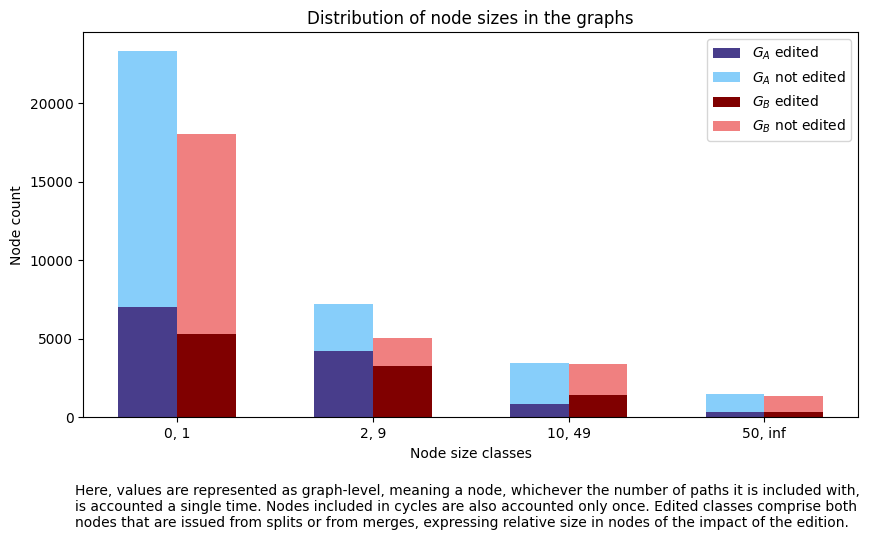

In [10]:
# Affichage des classes de noeuds

# Position of bars on x-axis
ind = arange(len(node_class_sizes))

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, node_A_edited_sizes, width, label='$G_A$ edited',color='darkslateblue',)
plt.bar(ind, [x-node_A_edited_sizes[i] for i,x in enumerate(node_A_class_sizes)], width, label='$G_A$ not edited',color='lightskyblue', bottom=node_A_edited_sizes)
plt.bar(ind + width, node_B_edited_sizes, width, label='$G_B$ edited',color='maroon')
plt.bar(ind + width, [x-node_B_edited_sizes[i] for i,x in enumerate(node_B_class_sizes)], width, label='$G_B$ not edited',bottom=node_B_edited_sizes,color='lightcoral')

plt.xlabel('Node size classes')
plt.ylabel('Node count')
plt.title('Distribution of node sizes in the graphs')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, [str(x)[1:-1] for x in node_class_sizes])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.annotate(
"""Here, values are represented as graph-level, meaning a node, whichever the number of paths it is included with,
is accounted a single time. Nodes included in cycles are also accounted only once. Edited classes comprise both
nodes that are issued from splits or from merges, expressing relative size in nodes of the impact of the edition.""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig("figures/distribution_node_sizes.png", bbox_inches='tight')
plt.show()

On peut également montrer la proportion de séquence impactée par ces éditions, en collapsant les classes mais en multipliant le noeud par sa taille, pour avoir le poids relatif de l'édition sur le graphe (= combien de bases sont dans des zones mésappareillées)

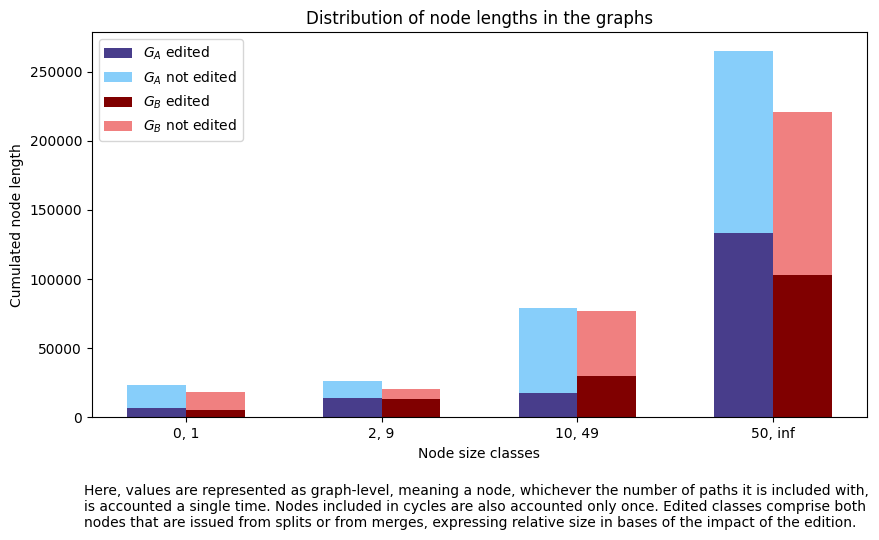

In [11]:
# Affichage des classes de noeuds

# Position of bars on x-axis
ind = arange(len(node_class_sizes))

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, node_A_edited_lengths, width, label='$G_A$ edited',color='darkslateblue',)
plt.bar(ind, [x-node_A_edited_lengths[i] for i,x in enumerate(node_A_class_lengths)], width, label='$G_A$ not edited',color='lightskyblue', bottom=node_A_edited_lengths)
plt.bar(ind + width, node_B_edited_lengths, width, label='$G_B$ edited',color='maroon')
plt.bar(ind + width, [x-node_B_edited_lengths[i] for i,x in enumerate(node_B_class_lengths)], width, label='$G_B$ not edited',bottom=node_B_edited_lengths,color='lightcoral')

plt.xlabel('Node size classes')
plt.ylabel('Cumulated node length')
plt.title('Distribution of node lengths in the graphs')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, [str(x)[1:-1] for x in node_class_sizes])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.annotate(
"""Here, values are represented as graph-level, meaning a node, whichever the number of paths it is included with,
is accounted a single time. Nodes included in cycles are also accounted only once. Edited classes comprise both
nodes that are issued from splits or from merges, expressing relative size in bases of the impact of the edition.""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("figures/distribution_node_lengths.png", bbox_inches='tight')
plt.show()

# Extraction d'informations à partir des éditions

Notre fichier est formaté comme suit :

`
{
    path: {
        merges: [
            pos,
            [
                node
            ],
            ...
        ],
        splits: [
            pos,
            [
                node
            ],
            ...
        ]
    }
}
`

## Mesure de la taille des opérations

Dans cette partie, on va se concentrer sur la taille des évènements (le nombre de bases qu'ils concernent)

Cela peut être calculé de différentes manières :

### A1) Distance minimale sans prise en compte des sous-découpes
+ Pour les splits, distance minimale entre bordure gauche et bordure droite par rapport au split
+ Pour les merges, la même chose mais du point de vue de l'autre graphe

In [12]:
# Calcul des valeurs de distance minimale
deltas_before:list[int] = list()
treated_nodes:set[tuple] = set()
for path_name,edition_profile in editions.items():
    for edit_type in ['merges','splits']:
        for position,[node_A,node_B] in edition_profile[edit_type]:
            if (node_A,node_B) not in treated_nodes:
                # Merges are read on the first graph, whereas splits are on the second
                if edit_type == 'merges':
                    for ofs_start,ofs_end,_ in cactus_gfa.segments[node_A]['PO'][path_name]:
                        if position >= ofs_start and position <= ofs_end:
                            deltas_before.append(min(abs(ofs_end-position),abs(position-ofs_start)))
                else:
                    for ofs_start,ofs_end,_ in pggb_gfa.segments[node_B]['PO'][path_name]:
                        if position >= ofs_start and position <= ofs_end:
                            deltas_before.append(min(abs(ofs_end-position),abs(position-ofs_start)))
                treated_nodes.add((node_A,node_B))

node_deltas_sizes_before: list[int] = [0 for _ in node_class_sizes]
node_deltas_lengths_before: list[int] = [0 for _ in node_class_sizes]

del treated_nodes
for delt in deltas_before:
    for i,(lower_bound,upper_bound) in enumerate(node_class_sizes):
        if delt >= lower_bound and delt <= upper_bound:
            node_deltas_sizes_before[i] += 1
            node_deltas_lengths_before[i] += delt

Le problème de cette méthode de calcul est qu'on ne prend pas en compte les multiples découpes pour un noeud. Cela donne juste l'information du sur-découpage des noeuds.

### A2) Distance minimale avec prise en compte des sous-découpes
+ Pour les splits, distance minimale entre bordure gauche et bordure droite par rapport au split
+ Pour les merges, la même chose mais du point de vue de l'autre graphe

Dans cette méthode, on a l'information de comment chaque édition interagit avec les autres. On recherche le plus proche breakpoint existant, qu'il soit réel ou fictif.

In [13]:
# Calcul des valeurs de distance minimale
deltas:list[int] = list()
treated_nodes:set[tuple] = set()
for path_name,edition_profile in editions.items():
    for edit_type in ['merges','splits']:
        for position,[node_A,node_B] in edition_profile[edit_type]:
            if (node_A,node_B) not in treated_nodes:
                # Merges are read on the first graph, whereas splits are on the second
                if edit_type == 'merges':
                    for ofs_start,ofs_end,_ in cactus_gfa.segments[node_A]['PO'][path_name]:
                        if position >= ofs_start and position <= ofs_end:
                            closest_event:list[int] = [abs(position-p) for p,_ in edition_profile['merges'] if p >= ofs_start and p <= ofs_end and p != position]
                            if len(closest_event) == 0:
                                event:int = float('inf')
                            else:
                                event:int = min(closest_event)
                            deltas.append(min(abs(ofs_end-position),abs(position-ofs_start),event))
                else:
                    for ofs_start,ofs_end,_ in pggb_gfa.segments[node_B]['PO'][path_name]:
                        if position >= ofs_start and position <= ofs_end:
                            closest_event:list[int] = [abs(position-p) for p,_ in edition_profile['splits'] if p >= ofs_start and p <= ofs_end and p != position]
                            if len(closest_event) == 0:
                                event:int = float('inf')
                            else:
                                event:int = min(closest_event)
                            deltas.append(min(abs(ofs_end-position),abs(position-ofs_start),event))
                treated_nodes.add((node_A,node_B))


node_deltas_sizes: list[int] = [0 for _ in node_class_sizes]
node_deltas_lengths: list[int] = [0 for _ in node_class_sizes]

del treated_nodes
for delt in deltas:
    for i,(lower_bound,upper_bound) in enumerate(node_class_sizes):
        if delt >= lower_bound and delt <= upper_bound:
            node_deltas_sizes[i] += 1
            node_deltas_lengths[i] += delt

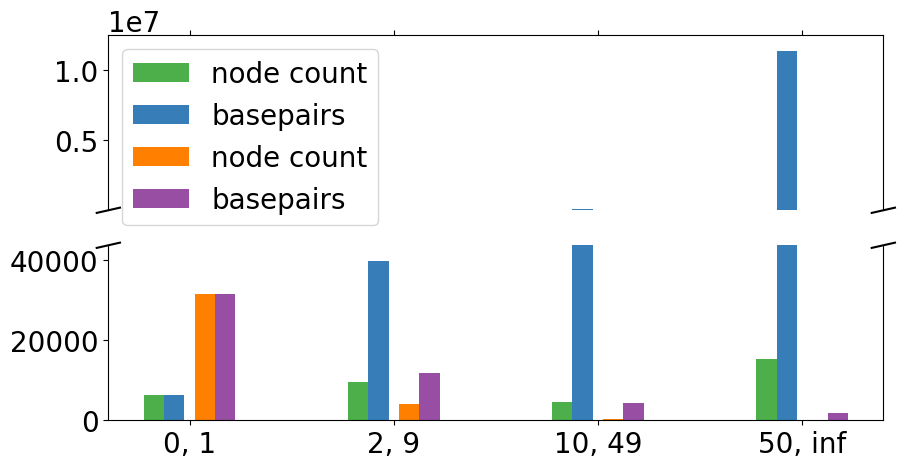

In [14]:
# Affichage des résultats de la distance minimale
plt.rcParams.update({'font.size': 20})
ind = arange(len(node_class_sizes))

f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(10,5))

maximum_values:list[int] = sorted(node_deltas_sizes_before + node_deltas_lengths_before + node_deltas_sizes + node_deltas_lengths)

width = .1

cb_colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 


# plot the same data on both axes
ax.bar(ind - 1.25*width, node_deltas_sizes_before, width, label='node count',color=cb_colors['green'],)
ax.bar(ind - .25 *width, node_deltas_lengths_before, width, label='basepairs',color=cb_colors['blue'],)
ax.bar(ind + 1.25*width, node_deltas_sizes, width, label='node count',color=cb_colors['orange'],)
ax.bar(ind + 2.25*width, node_deltas_lengths, width, label='basepairs',color=cb_colors['purple'],)
ax2.bar(ind - 1.25*width, node_deltas_sizes_before, width, label='node count',color=cb_colors['green'],)
ax2.bar(ind - .25 *width, node_deltas_lengths_before, width, label='basepairs',color=cb_colors['blue'],)
ax2.bar(ind + 1.25*width, node_deltas_sizes, width, label='node count',color=cb_colors['orange'],)
ax2.bar(ind + 2.25*width, node_deltas_lengths, width, label='basepairs',color=cb_colors['purple'],)


# zoom-in / limit the view to different portions of the data
ax.set_ylim(maximum_values[-3]*.8, maximum_values[-1]*1.10)  # outliers only
ax2.set_ylim(0, maximum_values[-3]*1.10)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax.set_xticks(ind + width / 2, [str(x)[1:-1] for x in node_class_sizes])
ax2.xaxis.tick_bottom()

d = .015 
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.legend(loc='upper left')

plt.savefig("figures/minimum_distance_breakpoint.png", bbox_inches='tight')
plt.show()

Text(0, -20, 'Minimum distance to breakpoint, accountig for other editions (purple) and not accounting for them (green).\nHere, we consider editions in regard to their projected version onto the consensus graph. Editions are at most over\n333bp, at min 1bp, with μ=1.37, Med=1 and σ=3.33 after the application of edition, whereas editions are applying\nat most on 5222bp, at min on 1bp, with μ=320.57, Med=19 and σ=670.38 before applying editions. ')

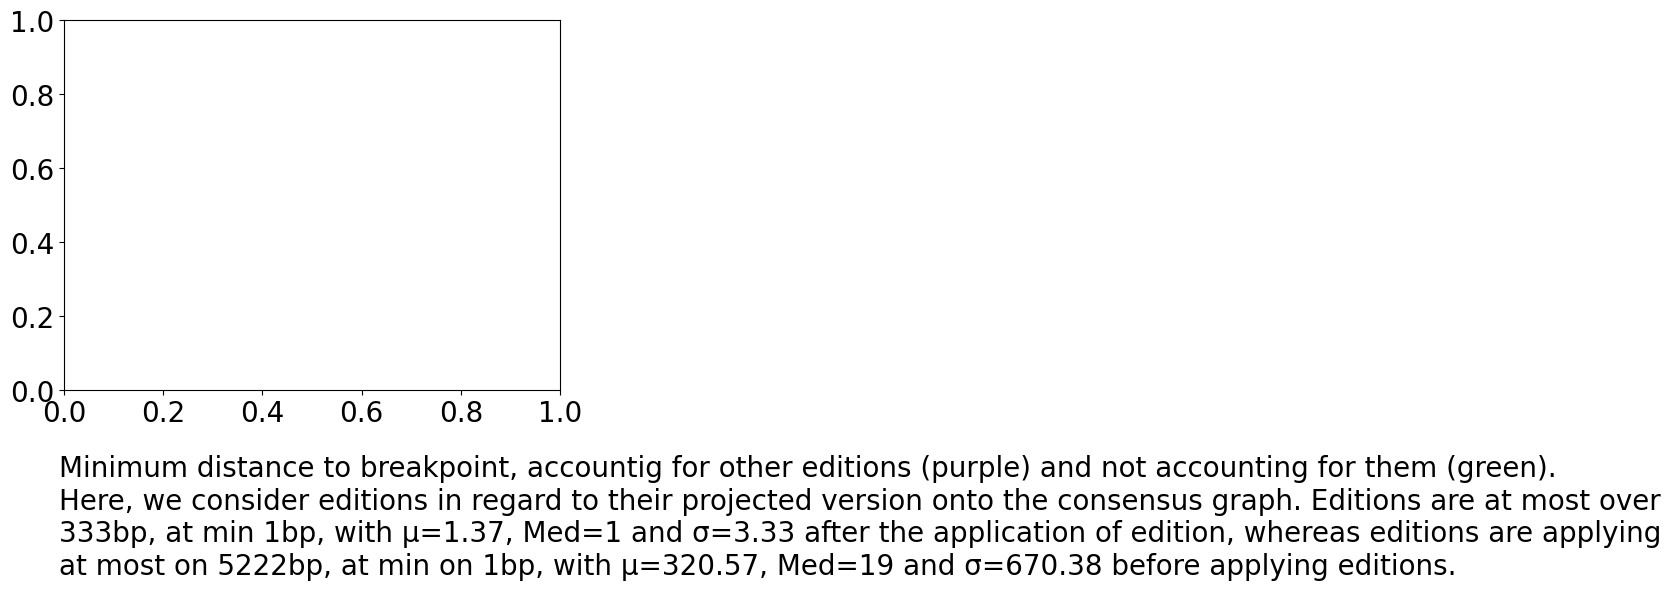

In [15]:
plt.annotate(
f"""Minimum distance to breakpoint, accountig for other editions (purple) and not accounting for them (green).
Here, we consider editions in regard to their projected version onto the consensus graph. Editions are at most over
{max(deltas)}bp, at min {min(deltas)}bp, with \u03BC={round(mean(deltas),2)}, Med={round(median(deltas),2)} and \u03C3={round(stdev(deltas),2)} after the application of edition, whereas editions are applying
at most on {max(deltas_before)}bp, at min on {min(deltas_before)}bp, with \u03BC={round(mean(deltas_before),2)}, Med={round(median(deltas_before),2)} and \u03C3={round(stdev(deltas_before),2)} before applying editions. """, (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')


### B) Densité des opérations
+ Nombre moyen d'opérations par noeud
    - pour les splits, nombre de découpes dans un noeud
    - pour les merges, nombre de merges pour obtenir un noeud

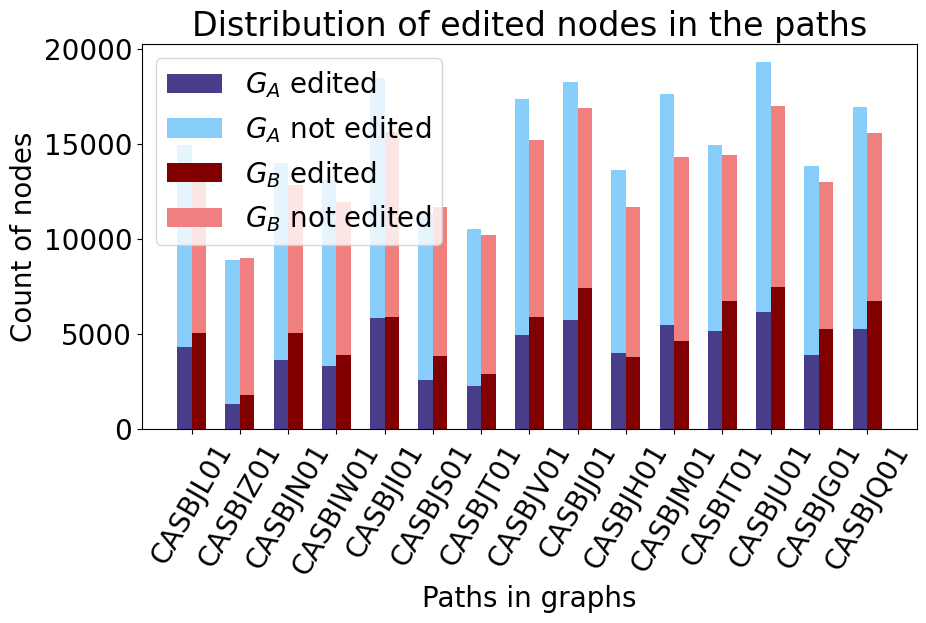

In [16]:
# Noeuds dans les éditions

# Affichage des classes de noeuds
graph_paths:list = list(set(cactus_gfa.paths.keys()).union(set(pggb_gfa.paths.keys())))
# Position of bars on x-axis
ind = arange(len(graph_paths))

raw_path_nodes_graph_A:list[int] = [0 for _ in graph_paths] # nombre total de noeuds dans chaque chemin
raw_path_nodes_graph_B:list[int] = [0 for _ in graph_paths] # nombre total de noeuds dans chaque chemin
edited_path_nodes_graph_A:list[int] = [0 for _ in graph_paths]
edited_path_nodes_graph_B:list[int] = [0 for _ in graph_paths]

for i,path_name in enumerate(graph_paths):
    if path_name in cactus_gfa.paths.keys():
        raw_path_nodes_graph_A[i] = len(set([x for x,_ in cactus_gfa.paths[path_name]['path']])-nodes_A_in_editions)
        edited_path_nodes_graph_A[i] = len(set([x for x,_ in cactus_gfa.paths[path_name]['path']]).intersection(nodes_A_in_editions))
    if path_name in pggb_gfa.paths.keys():
        raw_path_nodes_graph_B[i] = len(set([x for x,_ in pggb_gfa.paths[path_name]['path']])-nodes_B_in_editions)
        edited_path_nodes_graph_B[i] = len(set([x for x,_ in pggb_gfa.paths[path_name]['path']]).intersection(nodes_B_in_editions))

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, edited_path_nodes_graph_A, width, label='$G_A$ edited',color='darkslateblue',)
plt.bar(ind, raw_path_nodes_graph_A, width, label='$G_A$ not edited',color='lightskyblue', bottom=edited_path_nodes_graph_A)
plt.bar(ind + width, edited_path_nodes_graph_B, width, label='$G_B$ edited',color='maroon')
plt.bar(ind + width, raw_path_nodes_graph_B, width, label='$G_B$ not edited',bottom=edited_path_nodes_graph_B,color='lightcoral')

plt.xlabel('Paths in graphs')
plt.ylabel('Count of nodes')
plt.title('Distribution of edited nodes in the paths')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, graph_paths,rotation=60)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.annotate(
"""""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("figures/distribution_edited_nodes_paths.png", bbox_inches='tight')
plt.show()

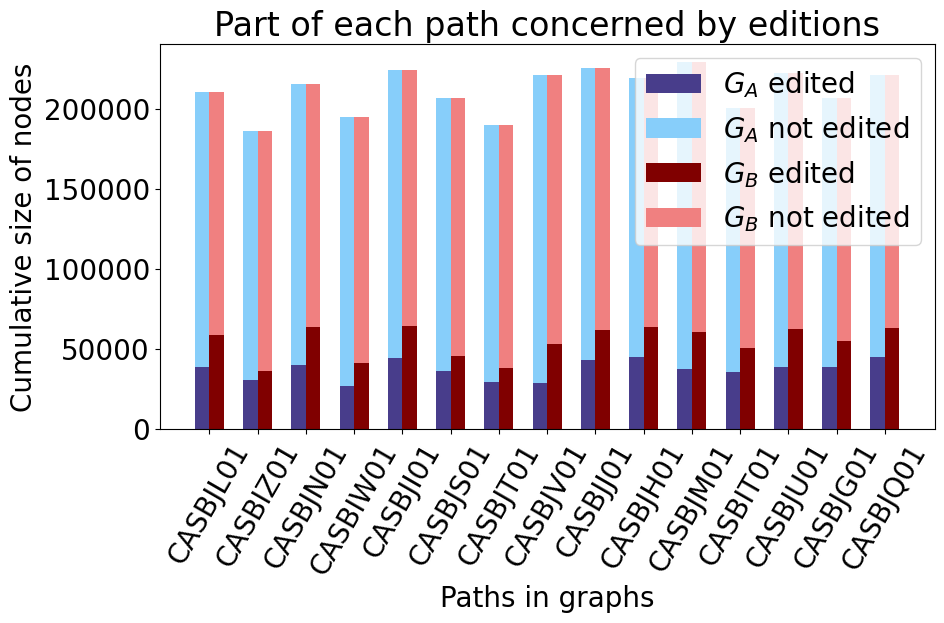

In [17]:
# Taille des noeuds dans les chemins

# Affichage des classes de noeuds
graph_paths:list = list(set(cactus_gfa.paths.keys()).union(set(pggb_gfa.paths.keys())))
# Position of bars on x-axis
ind = arange(len(graph_paths))

raw_path_nodes_graph_A:list[int] = [0 for _ in graph_paths] # nombre total de noeuds dans chaque chemin
raw_path_nodes_graph_B:list[int] = [0 for _ in graph_paths] # nombre total de noeuds dans chaque chemin
edited_path_nodes_graph_A:list[int] = [0 for _ in graph_paths]
edited_path_nodes_graph_B:list[int] = [0 for _ in graph_paths]

for i,path_name in enumerate(graph_paths):
    raw_A = set([x for x,_ in cactus_gfa.paths[path_name]['path']])-nodes_A_in_editions
    raw_B = set([x for x,_ in pggb_gfa.paths[path_name]['path']])-nodes_B_in_editions
    if path_name in cactus_gfa.paths.keys():
        for node,_ in cactus_gfa.paths[path_name]['path']:
            if node in raw_A:
                raw_path_nodes_graph_A[i] += graph_A_node_sizes[node]
            else:
                edited_path_nodes_graph_A[i] += graph_A_node_sizes[node]
    if path_name in pggb_gfa.paths.keys():
        for node,_ in pggb_gfa.paths[path_name]['path']:
            if node in raw_B:
                raw_path_nodes_graph_B[i] += graph_B_node_sizes[node]
            else:
                edited_path_nodes_graph_B[i] += graph_B_node_sizes[node]

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, edited_path_nodes_graph_A, width, label='$G_A$ edited',color='darkslateblue',)
plt.bar(ind, raw_path_nodes_graph_A, width, label='$G_A$ not edited',color='lightskyblue', bottom=edited_path_nodes_graph_A)
plt.bar(ind + width, edited_path_nodes_graph_B, width, label='$G_B$ edited',color='maroon')
plt.bar(ind + width, raw_path_nodes_graph_B, width, label='$G_B$ not edited',bottom=edited_path_nodes_graph_B,color='lightcoral')

plt.xlabel('Paths in graphs')
plt.ylabel('Cumulative size of nodes')
plt.title('Part of each path concerned by editions')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, graph_paths,rotation=60)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.annotate(
"""""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("figures/path_part_edition.png", bbox_inches='tight')
plt.show()

In [18]:
# Calcul de densité 
def count_group(lst):
    consec = [1]
    for x, y in zip(lst, lst[1:]):
        if x == y:
            consec[-1] += 1
        else:
            consec.append(1)
    return consec

nodes_A_splits:dict[str,list] = dict() 
nodes_B_splits:dict[str,list] = dict() 
nodes_A_merges:dict[str,list] = dict()
nodes_B_merges:dict[str,list] = dict()
for path_name,edition_profile in editions.items():
    # On doit exprimer, pour chaque noeud que l'on projette, sur combien de noeuds il est projeté.
    nodes_A_splits[path_name] = [node_A for _,[node_A,_] in edition_profile['splits']]
    nodes_B_splits[path_name] = [node_B for _,[_,node_B] in edition_profile['splits']]
    nodes_A_merges[path_name] = [node_A for _,[node_A,_] in edition_profile['merges']]
    nodes_B_merges[path_name] = [node_B for _,[_,node_B] in edition_profile['merges']]


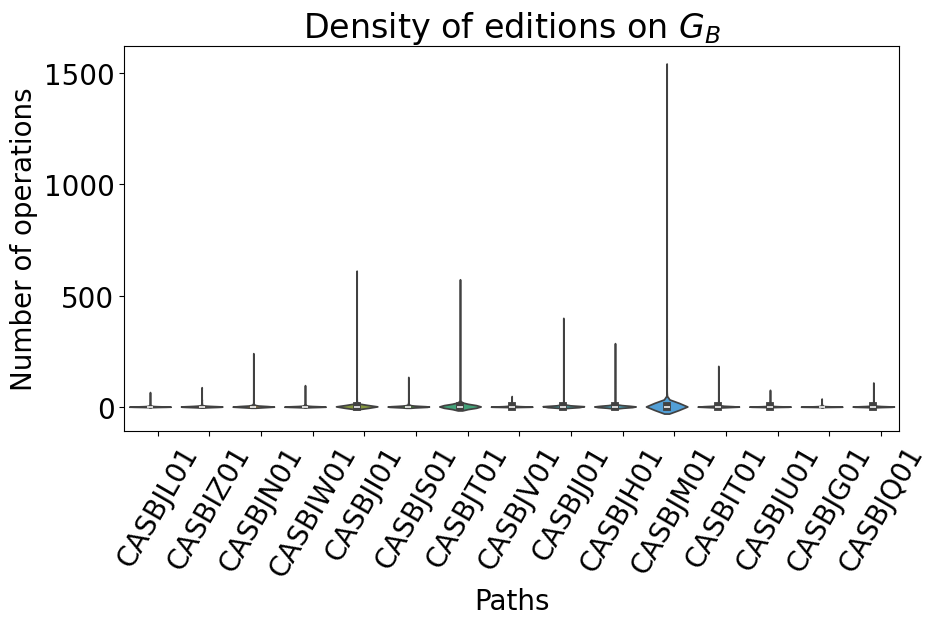

In [19]:
# Affichage des densités
plt.figure(figsize=(10,5))
violinplot(data=[count_group(nodes_B_splits[path_name]) for path_name in graph_paths])
plt.title("Density of editions on $G_B$")
plt.xticks(ind + width / 2, graph_paths,rotation=60)
plt.xlabel("Paths")
plt.ylabel("Number of operations")
plt.savefig("figures/editions_density_B.png", bbox_inches='tight')

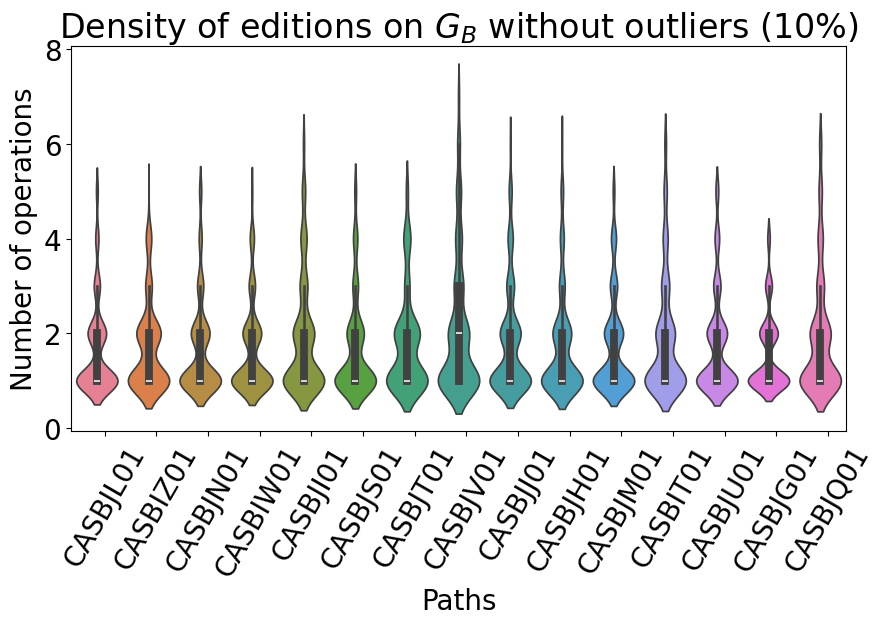

In [20]:
# Without outliers
plt.figure(figsize=(10,5))
violinplot(data=[sorted(y := count_group(nodes_B_splits[path_name]))[:-int(len(y)*.1)] for path_name in graph_paths])
plt.title("Density of editions on $G_B$ without outliers (10%)")
plt.xticks(ind + width / 2, graph_paths,rotation=60)
plt.xlabel("Paths")
plt.ylabel("Number of operations")
plt.savefig("figures/editions_density_no_outliers_B.png", bbox_inches='tight')

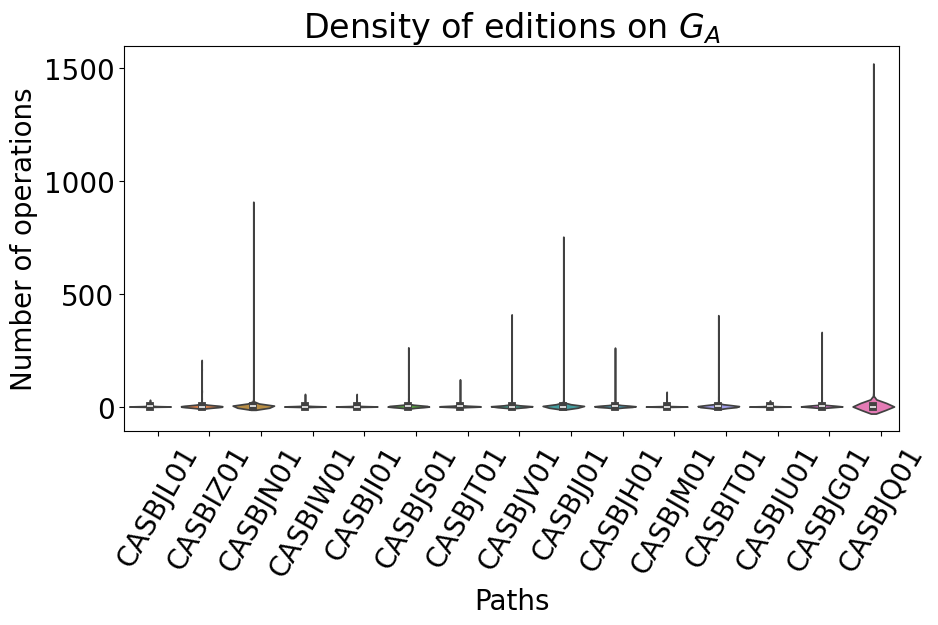

In [21]:
plt.figure(figsize=(10,5))
violinplot(data=[count_group(nodes_A_merges[path_name]) for path_name in graph_paths])
plt.title("Density of editions on $G_A$")
plt.xticks(ind + width / 2, graph_paths,rotation=60)
plt.xlabel("Paths")
plt.ylabel("Number of operations")
plt.savefig("figures/editions_density_A.png", bbox_inches='tight')

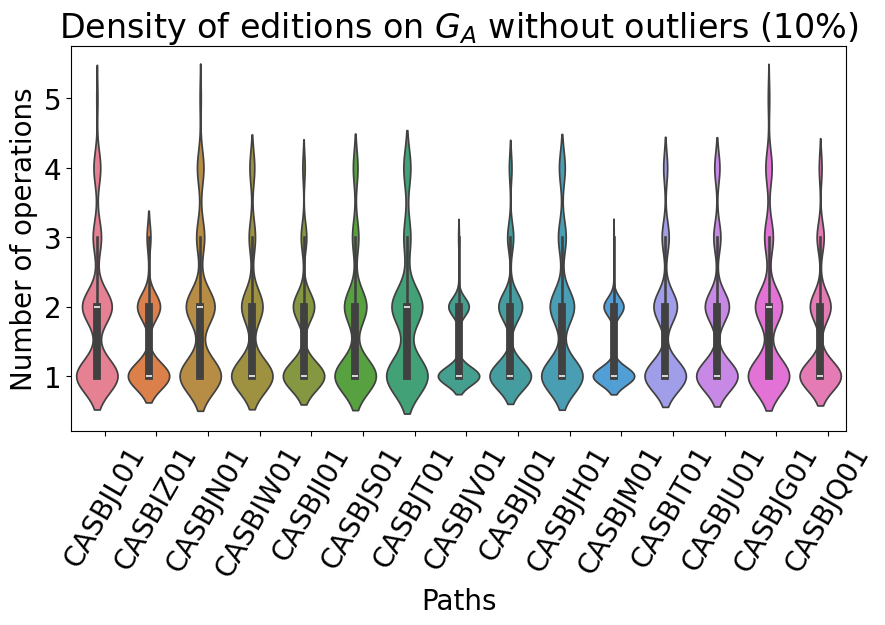

In [22]:
# Without outliers
plt.figure(figsize=(10,5))
violinplot(data=[sorted(y := count_group(nodes_A_merges[path_name]))[:-int(len(y)*.1)] for path_name in graph_paths])
plt.title("Density of editions on $G_A$ without outliers (10%)")
plt.xticks(ind + width / 2, graph_paths,rotation=60)
plt.xlabel("Paths")
plt.ylabel("Number of operations")
plt.savefig("figures/editions_density_no_outliers_A.png", bbox_inches='tight')

Queele proportion d'éditions concerne 1 paire de bases ?

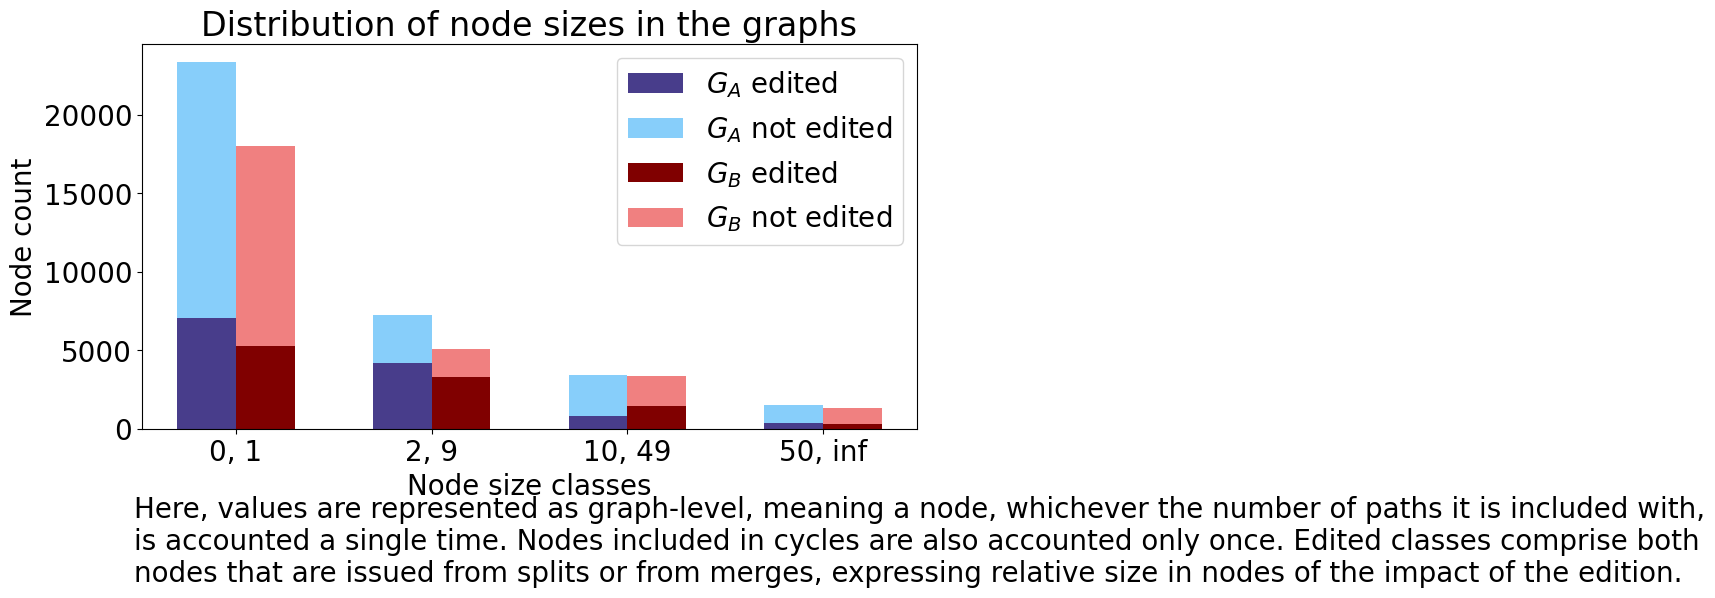

In [23]:
# Affichage des classes de noeuds

# Position of bars on x-axis
ind = arange(len(node_class_sizes))

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, node_A_edited_sizes, width, label='$G_A$ edited',color='darkslateblue',)
plt.bar(ind, [x-node_A_edited_sizes[i] for i,x in enumerate(node_A_class_sizes)], width, label='$G_A$ not edited',color='lightskyblue', bottom=node_A_edited_sizes)
plt.bar(ind + width, node_B_edited_sizes, width, label='$G_B$ edited',color='maroon')
plt.bar(ind + width, [x-node_B_edited_sizes[i] for i,x in enumerate(node_B_class_sizes)], width, label='$G_B$ not edited',bottom=node_B_edited_sizes,color='lightcoral')

plt.xlabel('Node size classes')
plt.ylabel('Node count')
plt.title('Distribution of node sizes in the graphs')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, [str(x)[1:-1] for x in node_class_sizes])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.annotate(
"""Here, values are represented as graph-level, meaning a node, whichever the number of paths it is included with,
is accounted a single time. Nodes included in cycles are also accounted only once. Edited classes comprise both
nodes that are issued from splits or from merges, expressing relative size in nodes of the impact of the edition.""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

### D) Etablissement d'un score

Afin de définir un score que l'on va pouvoir utiliser par la suite, il doit retranscrire différentes mesures :
- la densité des éditions
- la taille des éditions
- le ratio noeuds édités/non édités

<BarContainer object of 330 artists>

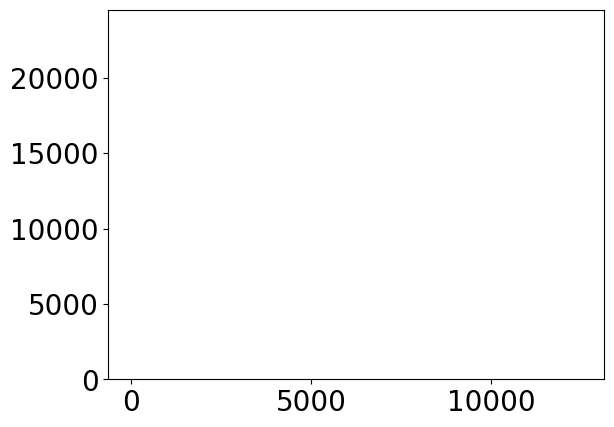

In [24]:
len_nodes:list[int] = [node['length'] for node in cactus_gfa.segments.values()]
vals_len_nodes = sorted([(x,y) for x,y in Counter(len_nodes).items()],key=lambda x:int(x[0]))

plt.bar([x for x,_ in vals_len_nodes],[y for _,y in vals_len_nodes])


## E) Exploration des distances mash entre séquences

L'objectif ici est de voir si le manque/présence d'édition et le taux de long noeuds peut être corréllé avec la distance ; l'hypothèse étant que plus les séquences sont divergentes plus les noeuds sont grands.

In [25]:
# Extract sequences and write them as files
sequences:dict = cactus_gfa.reconstruct_sequences()
for path_name,seq_generator in sequences.items():
    with open(f'temp/{path_name}.fa','w',encoding='utf-8') as fasta:
        fasta.write(f'>{path_name}\n'+''.join(list(seq_generator)))

In [26]:
mash:list[list[float]] = [
    [
    0 for _ in range(len(graph_paths))
] for _ in range(len(graph_paths))
    ]

for i,path_name_A in enumerate(graph_paths):
    for j,path_name_B in enumerate(graph_paths):
        mash[i][j]=float(run(['mash', 'dist',f'temp/{path_name_A}.fa',f'temp/{path_name_B}.fa'], stdout=PIPE).stdout.decode('utf-8').split()[2])
        
mash

Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL01.fa (provide sketch file made with "mash sketch" to skip)...done.
Sketching temp/CASBJL

[[0.0,
  0.0129677,
  0.00912584,
  0.0115761,
  0.0126347,
  0.0137488,
  0.0126347,
  0.011984,
  0.0112201,
  0.0132087,
  0.0174175,
  0.00892796,
  0.00892796,
  0.00694555,
  0.0105688],
 [0.0129677,
  0.0,
  0.0114865,
  0.0143537,
  0.0127767,
  0.0134036,
  0.00744966,
  0.0127767,
  0.0152404,
  0.0149234,
  0.0162193,
  0.0107836,
  0.0130638,
  0.010441,
  0.0124],
 [0.00912584,
  0.0114865,
  0.0,
  0.0125405,
  0.0129677,
  0.0127293,
  0.0115761,
  0.0117564,
  0.0120298,
  0.0130157,
  0.015347,
  0.00888862,
  0.0097316,
  0.00652391,
  0.0100623],
 [0.0115761,
  0.0143537,
  0.0125405,
  0.0,
  0.0141502,
  0.00726808,
  0.0143537,
  0.0170111,
  0.0133059,
  0.00594242,
  0.0184352,
  0.0134036,
  0.0136991,
  0.0125875,
  0.0168391],
 [0.0126347,
  0.0127767,
  0.0129677,
  0.0141502,
  0.0,
  0.0136496,
  0.0144049,
  0.0100623,
  0.0120298,
  0.014871,
  0.0160531,
  0.0097316,
  0.0106545,
  0.0106545,
  0.0100207],
 [0.0137488,
  0.0134036,
  0.0127293,
  0.0072

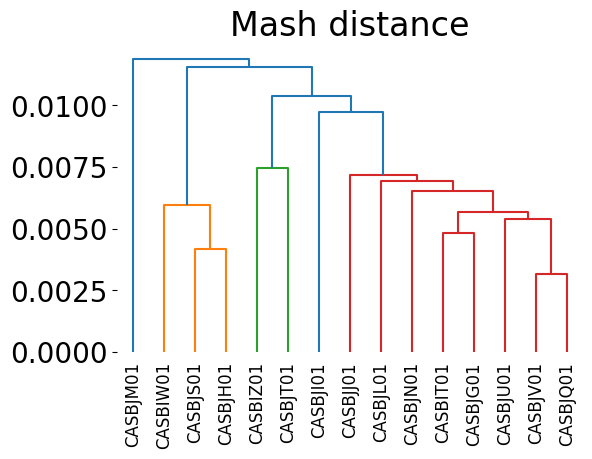

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [105.0, 105.0, 115.0, 115.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [110.0, 110.0, 132.5, 132.5],
  [95.0, 95.0, 121.25, 121.25],
  [85.0, 85.0, 108.125, 108.125],
  [75.0, 75.0, 96.5625, 96.5625],
  [65.0, 65.0, 85.78125, 85.78125],
  [50.0, 50.0, 75.390625, 75.390625],
  [22.5, 22.5, 62.6953125, 62.6953125],
  [5.0, 5.0, 42.59765625, 42.59765625]],
 'dcoord': [[0.0, 0.00417861, 0.00417861, 0.0],
  [0.0, 0.00594242, 0.00594242, 0.00417861],
  [0.0, 0.00744966, 0.00744966, 0.0],
  [0.0, 0.00483188, 0.00483188, 0.0],
  [0.0, 0.00316966, 0.00316966, 0.0],
  [0.0, 0.00541137, 0.00541137, 0.00316966],
  [0.00483188, 0.00567497, 0.00567497, 0.00541137],
  [0.0, 0.00652391, 0.00652391, 0.00567497],
  [0.0, 0.00694555, 0.00694555, 0.00652391],
  [0.0, 0.00719593, 0.00719593, 0.00694555],
  [0.0, 0.0097316, 0.0097316, 0.00719593],
  [0.00744966, 0.0103986, 0.0103986, 0.00

In [27]:
dists = squareform(mash)
linkage_matrix = linkage(dists, "single")
fig, ax = plt.subplots(figsize=(6,4))
color_list = dendrogram(linkage_matrix, labels=graph_paths)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks(rotation=90)
plt.title("Mash distance")
plt.savefig("figures/mash_tree.png", bbox_inches='tight')
plt.show()
color_list

### Calcul du taux de GC

In [28]:
gc_level:dict[str,Counter] = dict()
sequences:dict = cactus_gfa.reconstruct_sequences()
for path_name,seq_generator in sequences.items():
    gc_level[path_name] = Counter(''.join(list(seq_generator)))
    
all_nucleotides:list[str] = list(set([key for counts in gc_level.values() for key in counts.keys()]))
all_nucleotides

['C', 'N', 'A', 'G', 'T']

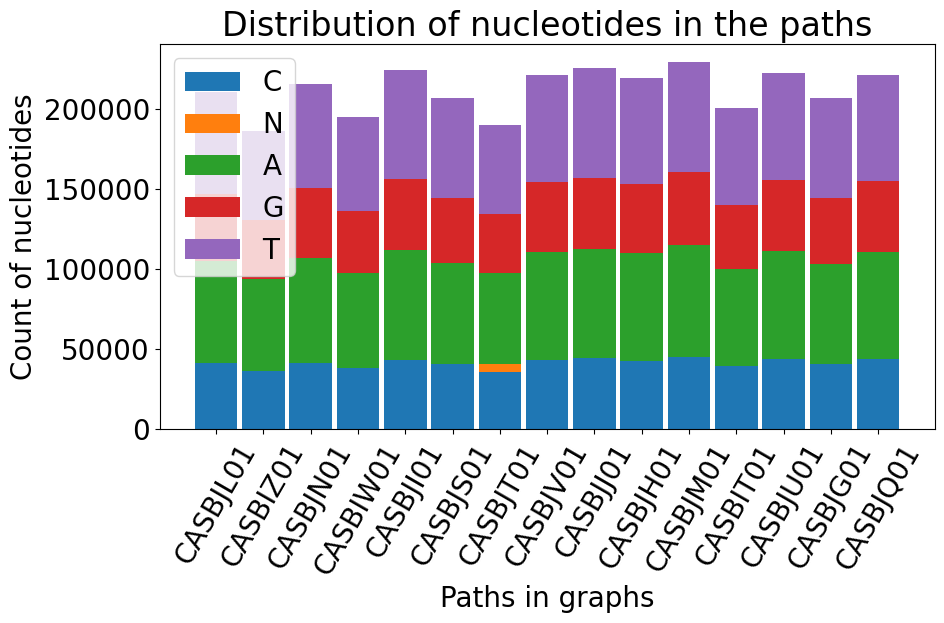

In [29]:
# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.9
ind = arange(len(graph_paths))

def sum_lists_diff_length(multilist:list,default:list=None):
    return ret_value if (ret_value := [sum(x) for x in zip(*map(lambda x: x + [0] * max(map(len, multilist)) if len(x) < max(map(len, multilist)) else x, multilist))]) else default


# Getting the tabs for each nucleotide
data_tables_content:list = [[gc_level[path_name].get(nucleotide,0) for path_name in graph_paths] for nucleotide in all_nucleotides]

# Plotting
for i,values in enumerate(data_tables_content):
    plt.bar(ind, values, width, label=all_nucleotides[i],bottom=sum_lists_diff_length(data_tables_content[0:i],default=[0 for _ in graph_paths]))

plt.xlabel('Paths in graphs')
plt.ylabel('Count of nucleotides')
plt.title('Distribution of nucleotides in the paths')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind, graph_paths,rotation=60)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.annotate(
"""""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("figures/nucleotides_paths_raw.png", bbox_inches='tight')
plt.show()

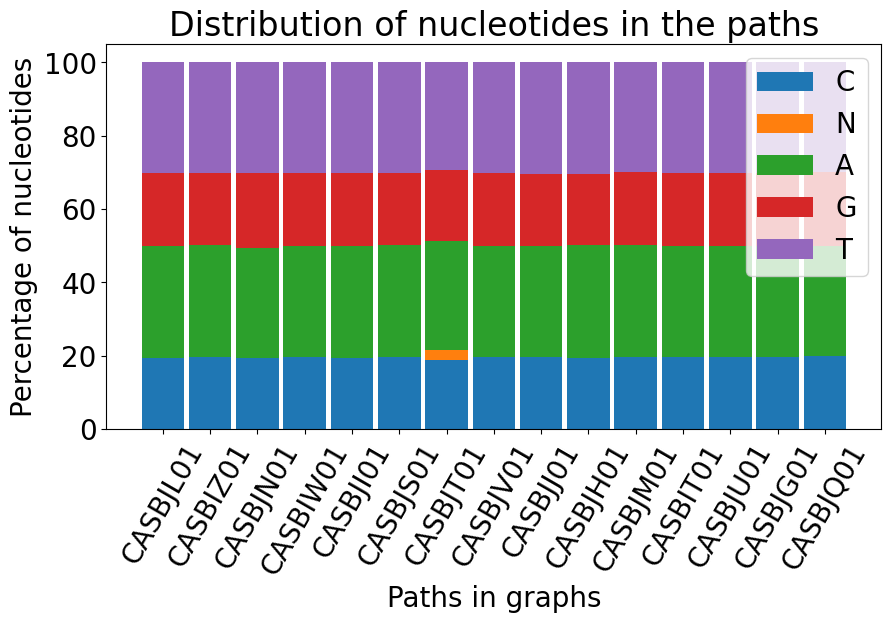

In [30]:
# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.9
ind = arange(len(graph_paths))

def sum_lists_diff_length(multilist:list,default:list=None):
    return ret_value if (ret_value := [sum(x) for x in zip(*map(lambda x: x + [0] * max(map(len, multilist)) if len(x) < max(map(len, multilist)) else x, multilist))]) else default


# Getting the tabs for each nucleotide
data_tables_content:list = [[gc_level[path_name].get(nucleotide,0) for path_name in graph_paths] for nucleotide in all_nucleotides]
data_total_content:list = sum_lists_diff_length(data_tables_content)
for data_list in data_tables_content:
    for i in range(len(data_list)):
        data_list[i] = data_list[i]/data_total_content[i]*100


# Plotting
for i,values in enumerate(data_tables_content):
    plt.bar(ind, values, width, label=all_nucleotides[i],bottom=sum_lists_diff_length(data_tables_content[0:i],default=[0 for _ in graph_paths]))

plt.xlabel('Paths in graphs')
plt.ylabel('Percentage of nucleotides')
plt.title('Distribution of nucleotides in the paths')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind, graph_paths,rotation=60)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.annotate(
"""""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("figures/nucleotides_paths_percentages.png", bbox_inches='tight')
plt.show()

Un des problèmes est de réussir à trouver une bonne représentation pour la distance au bord des noeuds des éditions.
Affichage de la distance à n'importe quel bord des éditions ?

(0.0, 10.0)

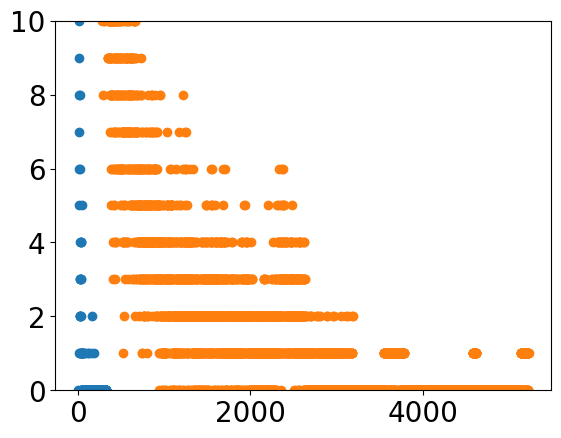

In [31]:
deltas_counts:Counter=Counter(deltas)
deltas_before_counts:Counter=Counter(deltas_before)
plt.scatter([i for i in range(max(deltas))],[deltas_counts.get(i,0) for i in range(max(deltas))])
plt.scatter([i+1 for i in range(max(deltas_before))],[deltas_before_counts.get(i+1,0) for i in range(max(deltas_before))])
plt.ylim(0,10)

On va d'abord calculer les projections des noeuds d'un graphe sur l'autre.
Une fois que cette opération sera faite, on pourra utiliser la librairie MNE pour représenter la projection et la segmentation d'un unique noeud.

In [32]:
def compute_projection(node:str,graph_A:Graph,graph_B:Graph) -> dict[str,list[list[str]]]:
    """Renvoie la/les liste.s des noeuds du grapheB qui sont la projection du noeud du grapheA
    Se base sur les tags PO qui sont supposés être précalculés

    Returns:
        dict[str,list[list[str]]]: liste de projections par chemin
    """
    projections:dict = dict()
    if node not in graph_A.segments.keys():
        return projections
    for path_name,po_tag_list in graph_A.segments[node]['PO'].items():
        projections[path_name] = list()
        for start_ofs,stop_ofs,_ in po_tag_list:
            encountered_nodes:dict = dict()
            for pggb_node,_ in graph_B.paths[path_name]['path']:
                encountered_nodes[pggb_node] = 1 + encountered_nodes.get(pggb_node,-1)
                po_start,po_end,_ = graph_B.segments[pggb_node]['PO'][path_name][encountered_nodes[pggb_node]]
                if po_end > start_ofs and po_start < stop_ofs:
                    projections[path_name].append(pggb_node)
    return projections

def number_nodes_in_projection(projections:dict) -> int:
    return len(set().union(*[x for x in projections.values()]))

def max_density(projections:dict) -> int:
    return max([len(x) for x in projections.values()])

Démo du fonctionnement du calcul de projection

In [33]:
print(f"Computing projections for node {(cactus_node := choice(list(nodes_A_in_editions)))} with {len(cactus_gfa.segments[cactus_node]['PO'])} paths in it.")
compute_projection(cactus_node,cactus_gfa,pggb_gfa)

Computing projections for node 3170 with 1 paths in it.


{'CASBJN01': ['13333']}

On peut calculer, pour chaque noeud, l'ensemble des projections sur l'autre graphe. C'est une autre forme de mesure de densité.
On peut comparer cette densité à la densité brute, pour voir si dans la moyenne on a la même densité de projection pour les noeuds édités et non édités.

In [34]:
nodes_A_not_in_editions:set = set(cactus_gfa.segments.keys()) - nodes_A_in_editions
sample:int = 1000
alpha = choices(list(nodes_A_in_editions),k=sample)
beta = choices(list(nodes_A_not_in_editions),k=sample)


dataset_densities:list = [
    [
        number_nodes_in_projection(
            compute_projection(
                my_node,
                cactus_gfa,
                pggb_gfa
            )
        ) for my_node in alpha
    ],
    [
        number_nodes_in_projection(
            compute_projection(
                my_node,
                cactus_gfa,
                pggb_gfa
            )
        ) for my_node in beta
    ],
    [
        max_density(
            compute_projection(
                my_node,
                cactus_gfa,
                pggb_gfa
            )
        ) for my_node in alpha
    ],
    [
        max_density(
            compute_projection(
                my_node,
                cactus_gfa,
                pggb_gfa
            )
        ) for my_node in beta
    ]
]

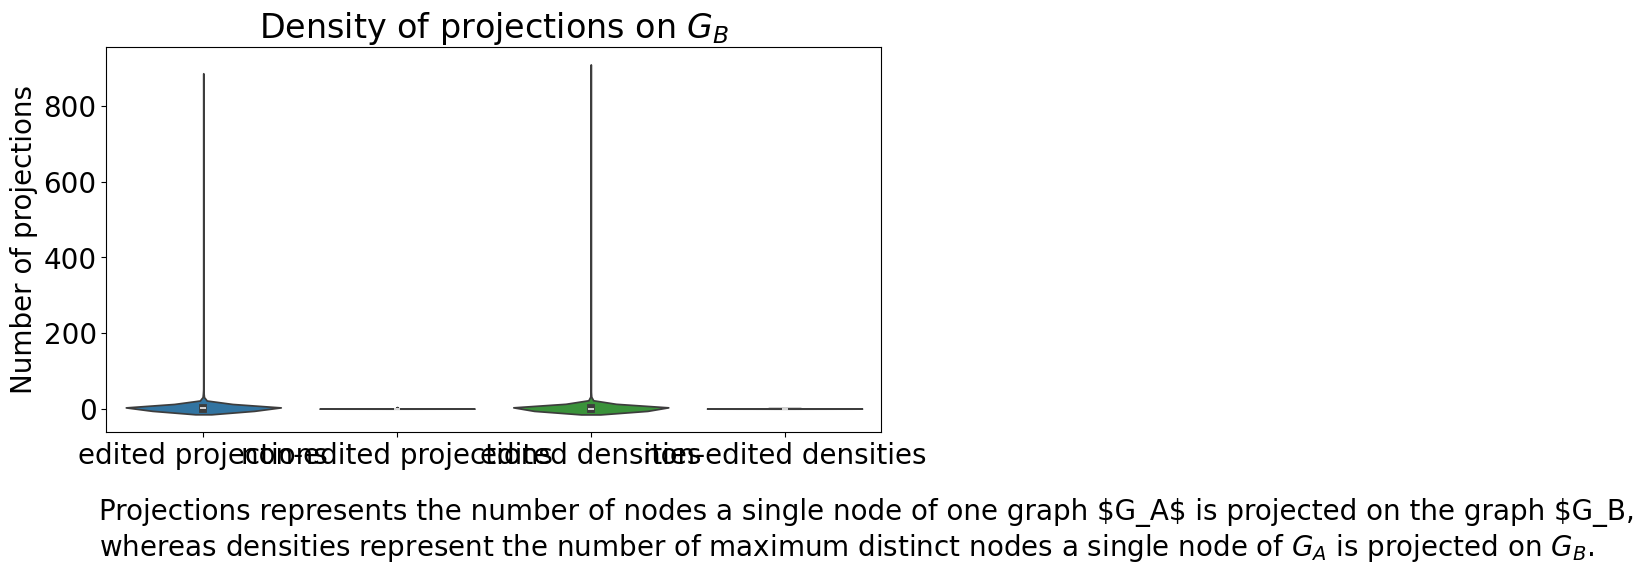

In [35]:
# Affichage des densités de projections
plt.figure(figsize=(10,5))
violinplot(data=dataset_densities)
plt.title("Density of projections on $G_B$")
plt.xticks([0,1,2,3], ['edited projections','non-edited projections','edited densities','non-edited densities'])
plt.ylabel("Number of projections")
plt.annotate(
"""Projections represents the number of nodes a single node of one graph $G_A$ is projected on the graph $G_B,
whereas densities represent the number of maximum distinct nodes a single node of $G_A$ is projected on $G_B$.""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("figures/projections_B.png", bbox_inches='tight')

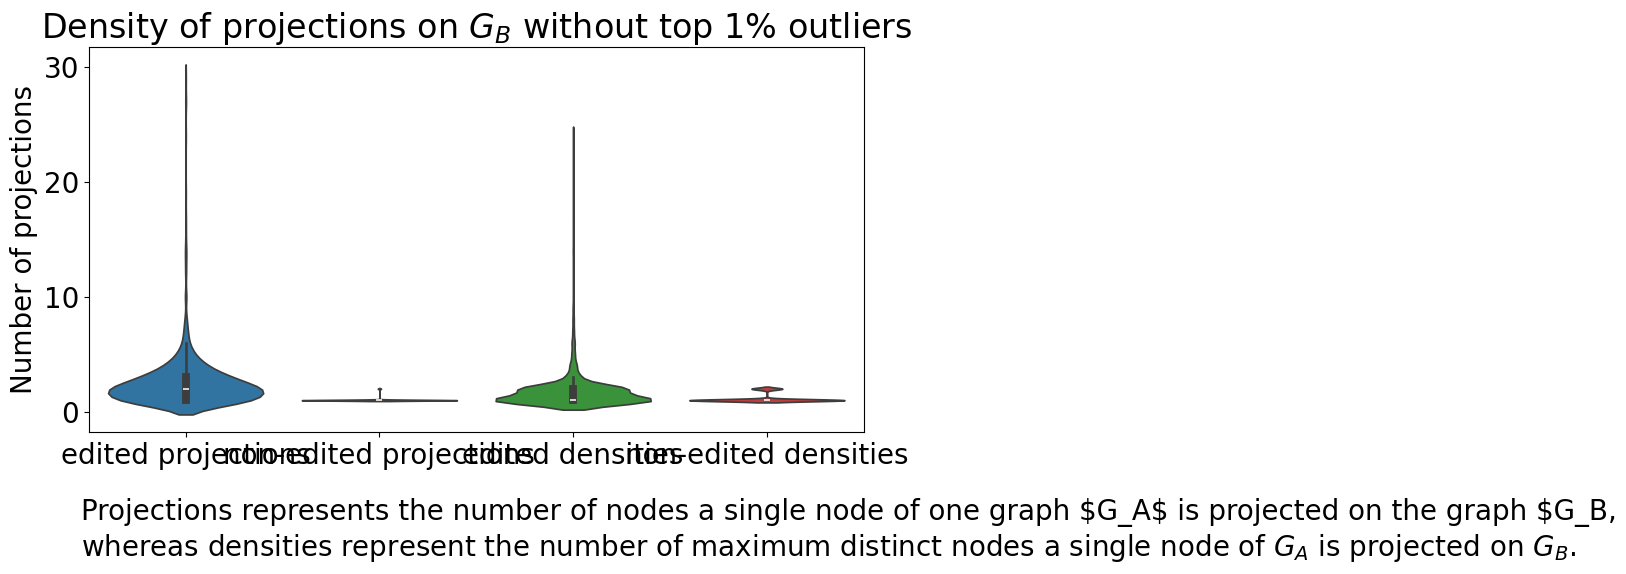

In [36]:
# Affichage des densités de projections sans 1% outliers
plt.figure(figsize=(10,5))
violinplot(data=[sorted(x)[:-int(len(x)*.01)] for x in dataset_densities])
plt.title("Density of projections on $G_B$ without top 1% outliers")
plt.xticks([0,1,2,3], ['edited projections','non-edited projections','edited densities','non-edited densities'])
plt.ylabel("Number of projections")
plt.annotate(
"""Projections represents the number of nodes a single node of one graph $G_A$ is projected on the graph $G_B,
whereas densities represent the number of maximum distinct nodes a single node of $G_A$ is projected on $G_B$.""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("figures/projections_no_outliers_B.png", bbox_inches='tight')

Est-ce que les grands noeuds sont coupés uniquement aux extrémités ?

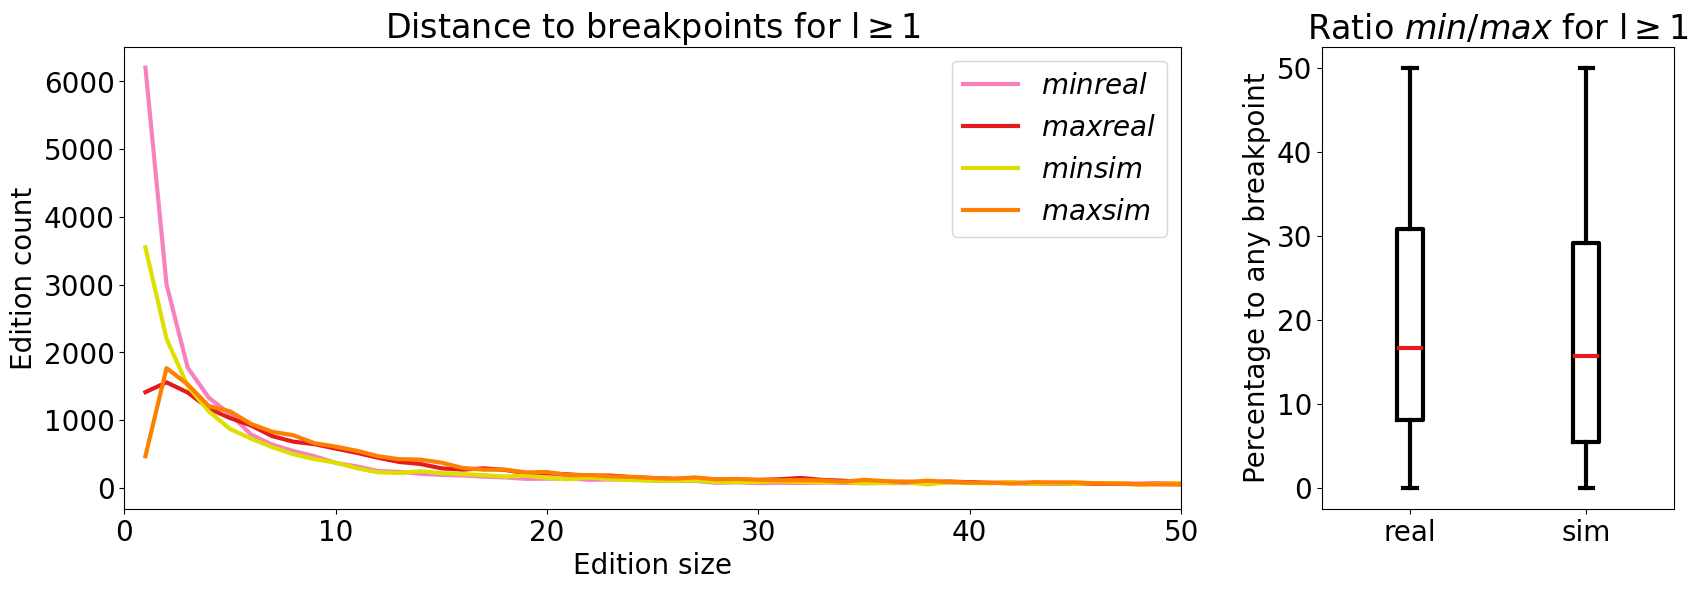

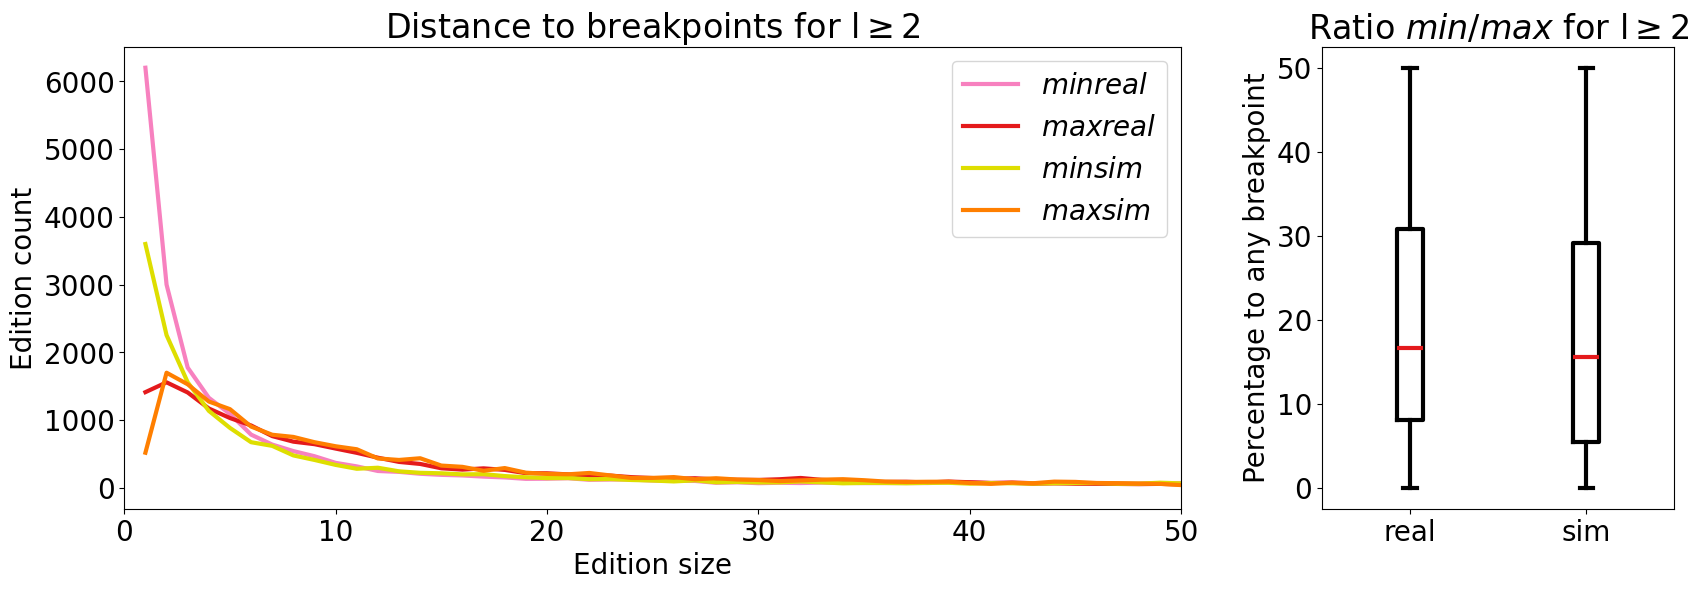

In [37]:
seed(124)
plt.rcParams.update({'font.size': 20})

for threshold in range(1,3):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6), gridspec_kw={'width_ratios': [3, 1]})

    deltas_before:list[int] = list()
    deltas_before_max:list[int] = list()
    deltas_rand_before:list[int] = list()
    deltas_rand_before_max:list[int] = list()
    treated_nodes:set[tuple] = set()
    for path_name,edition_profile in editions.items():
        for edit_type in ['merges','splits']:
            for position,[node_A,node_B] in edition_profile[edit_type]:
                if (node_A,node_B) not in treated_nodes:
                    # Merges are read on the first graph, whereas splits are on the second
                    if edit_type == 'merges' and cactus_gfa.segments[node_A]['length']>= threshold:
                        for ofs_start,ofs_end,_ in cactus_gfa.segments[node_A]['PO'][path_name]:
                            if position >= ofs_start and position <= ofs_end:
                                rand_pos:int = randint(ofs_start,ofs_end)
                                deltas_before.append(min(abs(ofs_end-position),abs(position-ofs_start)))
                                deltas_before_max.append(max(abs(ofs_end-position),abs(position-ofs_start)))
                                deltas_rand_before.append(min(abs(ofs_end-rand_pos),abs(rand_pos-ofs_start)))
                                deltas_rand_before_max.append(max(abs(ofs_end-rand_pos),abs(rand_pos-ofs_start)))
                    elif edit_type == 'splits' and pggb_gfa.segments[node_B]['length'] >= threshold:
                        for ofs_start,ofs_end,_ in pggb_gfa.segments[node_B]['PO'][path_name]:
                            if position >= ofs_start and position <= ofs_end:
                                rand_pos:int = randint(ofs_start,ofs_end)
                                deltas_before.append(min(abs(ofs_end-position),abs(position-ofs_start)))
                                deltas_before_max.append(max(abs(ofs_end-position),abs(position-ofs_start)))
                                deltas_rand_before.append(min(abs(ofs_end-rand_pos),abs(rand_pos-ofs_start)))
                                deltas_rand_before_max.append(max(abs(ofs_end-rand_pos),abs(rand_pos-ofs_start)))
                    treated_nodes.add((node_A,node_B))

    node_deltas_sizes_before: list[int] = [0 for _ in node_class_sizes]
    node_deltas_lengths_before: list[int] = [0 for _ in node_class_sizes]

    del treated_nodes
    for delt in deltas_before:
        for i,(lower_bound,upper_bound) in enumerate(node_class_sizes):
            if delt >= lower_bound and delt <= upper_bound:
                node_deltas_sizes_before[i] += 1
                node_deltas_lengths_before[i] += delt


    deltas_before_counts:Counter=Counter(deltas_before)
    deltas_before_counts_max:Counter=Counter(deltas_before_max)
    deltas_rand_before_counts:Counter=Counter(deltas_rand_before)
    deltas_rand_before_counts_max:Counter=Counter(deltas_rand_before_max)
    ax1.plot([i+1 for i in range(max(deltas_before))],[deltas_before_counts.get(i+1,0) for i in range(max(deltas_before))],label='$min real$',color=cb_colors['pink'],linewidth=3)
    ax1.plot([i+1 for i in range(max(deltas_before_max))],[deltas_before_counts_max.get(i+1,0) for i in range(max(deltas_before_max))], label='$max real$',color=cb_colors['red'],linewidth=3)
    ax1.plot([i+1 for i in range(max(deltas_rand_before))],[deltas_rand_before_counts.get(i+1,0) for i in range(max(deltas_rand_before))],label='$min sim$',color=cb_colors['yellow'],linewidth=3)
    ax1.plot([i+1 for i in range(max(deltas_rand_before_max))],[deltas_rand_before_counts_max.get(i+1,0) for i in range(max(deltas_rand_before_max))], label='$max sim$',color=cb_colors['orange'],linewidth=3)
    ax1.legend()

    ax2.boxplot([
        [deltas_before[i]/deltas_before_max[i]*50 for i in range(len(deltas_before))],
        [deltas_rand_before[i]/deltas_rand_before_max[i]*50 for i in range(len(deltas_rand_before))],
    ],whiskerprops = dict(linewidth=3),
    boxprops= dict(linewidth=3),
    capprops= dict(linewidth=3),
    medianprops={"linewidth": 3, "color": cb_colors['red'],},
    )
    ax1.set_ylabel(f"Edition count")
    ax1.set_xlabel(f"Edition size")
    ax1.set_title(f"Distance to breakpoints for l$\geq {threshold}$")

    ax1.set_xlim(0,50)

    ax2.set_title(f"Ratio $min/max$ for l$\geq {threshold}$")
    ax2.set_xticks([1,2],['real','sim'])
    ax2.set_ylabel("Percentage to any breakpoint")
    plt.savefig(f"temp/anim_breakpoints_{str(threshold).zfill(3)}.png",bbox_inches='tight')

    ax1.annotate(
"""The distances to breakpoints represent the distances from any editions to any border of node they are included in. A $min$ distance of 1 means the edition
happens at a distance of one basepair from the left or right tip of the node, while a max distance of 10 means the farthest distance to a breakpoint is of
size 10 for this edition.""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')

    ax2.annotate(
"""As we compute the ratio between min and max, the
max value is reached if the edition is at the exact
center of the node, while the lowest values correspond
to editions at the border of nodes""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')


### Représentation des classes de taille de noeuds par chemin

- Subdiviser en plus de classes
- Choisir quelques génomes à des points différents du clustering

CASBJL01 : [2154, 1621, 532, 189] - [6124, 1639, 2015, 1051]
CASBIZ01 : [634, 496, 145, 70] - [3960, 961, 1608, 1017]
CASBJN01 : [1741, 1266, 445, 178] - [5799, 1573, 1974, 1045]
CASBIW01 : [1605, 1282, 328, 103] - [5427, 1464, 1850, 1054]
CASBJI01 : [3082, 2263, 413, 106] - [6926, 2279, 2353, 1032]
CASBJS01 : [1354, 859, 268, 125] - [4706, 1199, 1753, 1092]
CASBJT01 : [1211, 747, 218, 92] - [4428, 1137, 1695, 988]
CASBJV01 : [4199, 3077, 378, 58] - [8292, 3014, 2799, 1026]
CASBJJ01 : [2895, 2228, 486, 154] - [6925, 2191, 2333, 1054]
CASBJH01 : [2100, 1353, 402, 165] - [5316, 1344, 1873, 1098]
CASBJM01 : [4633, 3154, 456, 99] - [7803, 2970, 2789, 1026]
CASBIT01 : [2759, 1935, 371, 114] - [5461, 1453, 1842, 1032]
CASBJU01 : [3085, 2392, 543, 155] - [7296, 2334, 2441, 1047]
CASBJG01 : [1825, 1405, 465, 177] - [5581, 1428, 1901, 1047]
CASBJQ01 : [2700, 2060, 378, 118] - [6366, 2026, 2262, 1024]


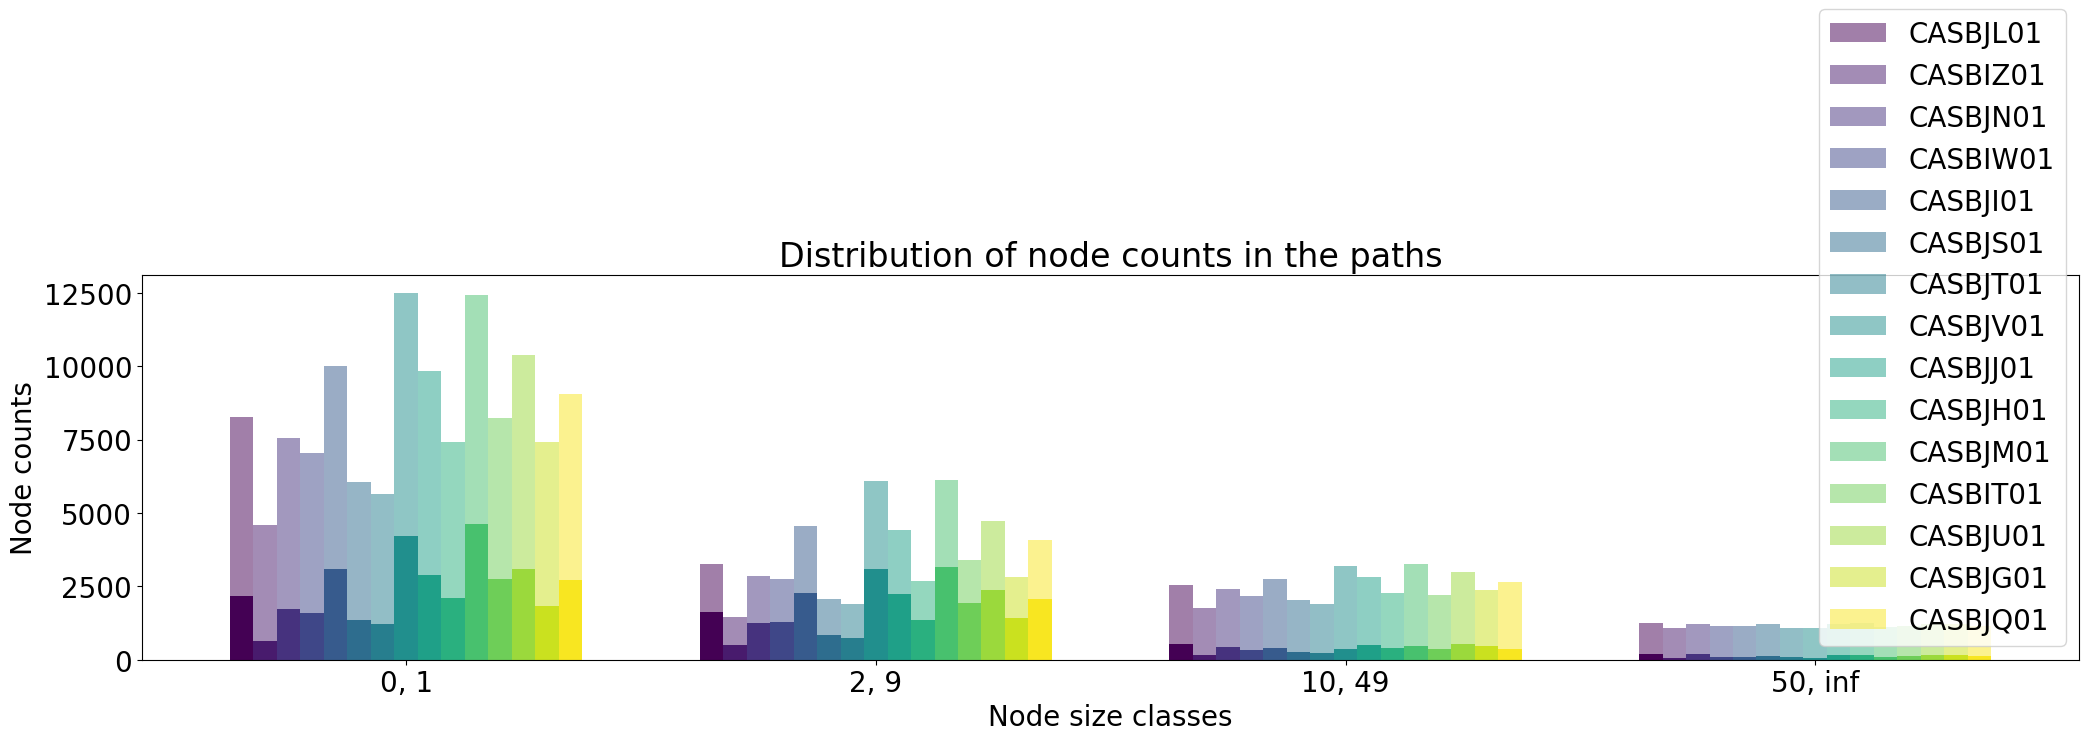

In [38]:
# Affichage des classes de noeuds

# Position of bars on x-axis
ind = arange(len(node_class_sizes))

# Figure size
plt.figure(figsize=(25,5))

# Width of a bar 
width = 0.05

path_palette:list = get_palette_from_list(list(range(len(graph_paths))))   

# Plotting
for j,path_name in enumerate(graph_paths):
    edited_path_nodes:list = [0 for _ in node_class_sizes]
    raw_path_nodes:list = [0 for _ in node_class_sizes]
    
    for node,_ in cactus_gfa.paths[path_name]['path']:
        for i,(inf,sup) in enumerate(node_class_sizes):
            if cactus_gfa.segments[node]['length'] >= inf and cactus_gfa.segments[node]['length'] <= sup:
                if node in nodes_A_in_editions:
                    edited_path_nodes[i] += 1
                else:
                    raw_path_nodes[i] += 1
    print(f"{path_name} : {edited_path_nodes} - {raw_path_nodes}")
    plt.bar(ind+width*j, edited_path_nodes, width,color=path_palette[j],)
    plt.bar(ind+width*j, raw_path_nodes, width, label=f'{path_name}',color=path_palette[j], bottom=edited_path_nodes, alpha=.5)


plt.xlabel('Node size classes')
plt.ylabel('Node counts')
plt.title('Distribution of node counts in the paths')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width*len(graph_paths)/2 -.025, [str(x)[1:-1] for x in node_class_sizes])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.annotate(
"""""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("figures/nodes_counts_distribution_paths.png", bbox_inches='tight')
plt.show()

CASBJL01 : [2154, 5786, 11721, 19081] - [6124, 7334, 49210, 109105]
CASBIZ01 : [634, 1859, 3291, 24798] - [3960, 4573, 40333, 106861]
CASBJN01 : [1741, 4485, 10254, 23611] - [5799, 7155, 48150, 114311]
CASBIW01 : [1605, 4586, 7093, 13588] - [5427, 6600, 45231, 110706]
CASBJI01 : [3082, 8006, 8431, 25088] - [6926, 10195, 54880, 107551]
CASBJS01 : [1354, 3100, 6039, 25721] - [4706, 5580, 43730, 116245]
CASBJT01 : [1211, 2633, 4885, 20655] - [4428, 5400, 41832, 109010]
CASBJV01 : [4199, 10705, 6950, 6927] - [8292, 13473, 63445, 106923]
CASBJJ01 : [2895, 7901, 10254, 22216] - [6925, 9821, 54844, 110228]
CASBJH01 : [2100, 4790, 8965, 28819] - [5316, 6229, 46192, 116897]
CASBJM01 : [4633, 10958, 9044, 13005] - [7803, 13370, 63147, 106923]
CASBIT01 : [2759, 6851, 7653, 18195] - [5461, 6515, 45231, 107646]
CASBJU01 : [3085, 8569, 11213, 15832] - [7296, 10433, 57131, 108865]
CASBJG01 : [1825, 5149, 10328, 21390] - [5581, 6431, 46926, 108834]
CASBJQ01 : [2700, 7175, 7648, 27569] - [6366, 9044, 5

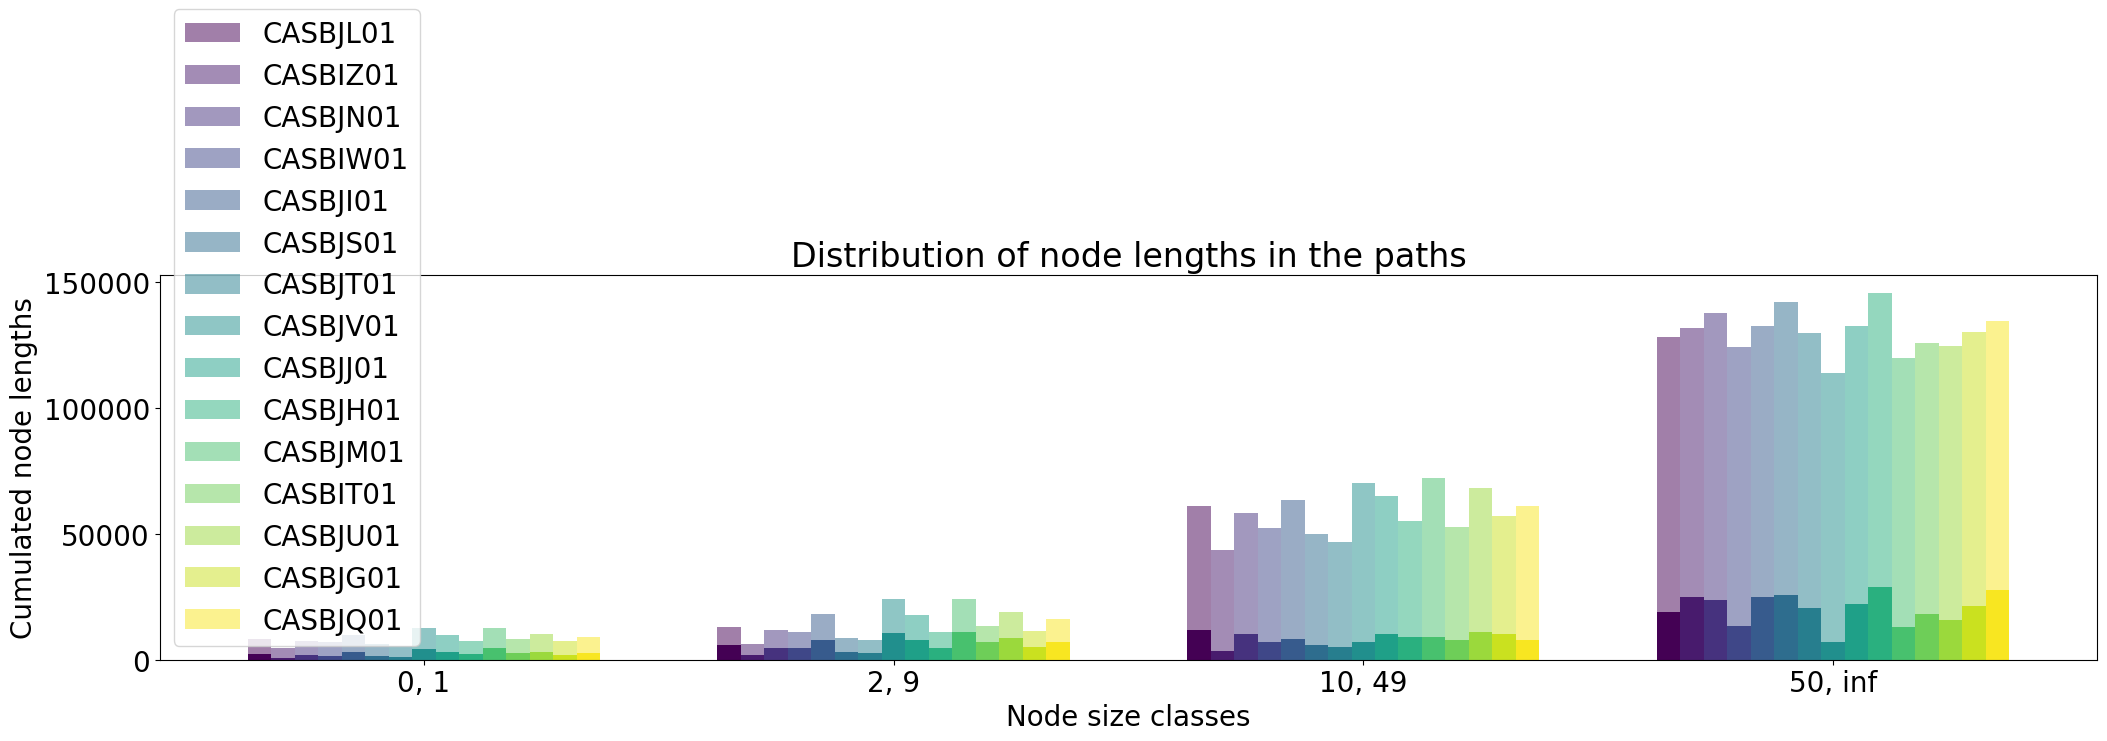

<Figure size 640x480 with 0 Axes>

In [39]:
# Affichage des classes de noeuds

# Position of bars on x-axis
ind = arange(len(node_class_sizes))

# Figure size
plt.figure(figsize=(25,5))

# Width of a bar 
width = 0.05

path_palette:list = get_palette_from_list(list(range(len(graph_paths))))   

# Plotting
for j,path_name in enumerate(graph_paths):
    edited_path_nodes:list = [0 for _ in node_class_sizes]
    raw_path_nodes:list = [0 for _ in node_class_sizes]
    
    for node,_ in cactus_gfa.paths[path_name]['path']:
        for i,(inf,sup) in enumerate(node_class_sizes):
            if cactus_gfa.segments[node]['length'] >= inf and cactus_gfa.segments[node]['length'] <= sup:
                if node in nodes_A_in_editions:
                    edited_path_nodes[i] += cactus_gfa.segments[node]['length']
                else:
                    raw_path_nodes[i] += cactus_gfa.segments[node]['length']
    print(f"{path_name} : {edited_path_nodes} - {raw_path_nodes}")
    plt.bar(ind+width*j, edited_path_nodes, width,color=path_palette[j],)
    plt.bar(ind+width*j, raw_path_nodes, width, label=f'{path_name}',color=path_palette[j], bottom=edited_path_nodes, alpha=.5)


plt.xlabel('Node size classes')
plt.ylabel('Cumulated node lengths')
plt.title('Distribution of node lengths in the paths')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width*len(graph_paths)/2 -.025, [str(x)[1:-1] for x in node_class_sizes])

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.annotate(
"""""", (-0.01,-0.1), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()
plt.savefig("figures/nodes_lengths_distribution_paths.png", bbox_inches='tight')

### Clustering des partages de noeuds

- mettre en lien l'arbre obtenu avec la mash distance
- à exprimer en noeuds et en bp
- en virant les SNPs

... en faisant un clustering des SNPs uniquement

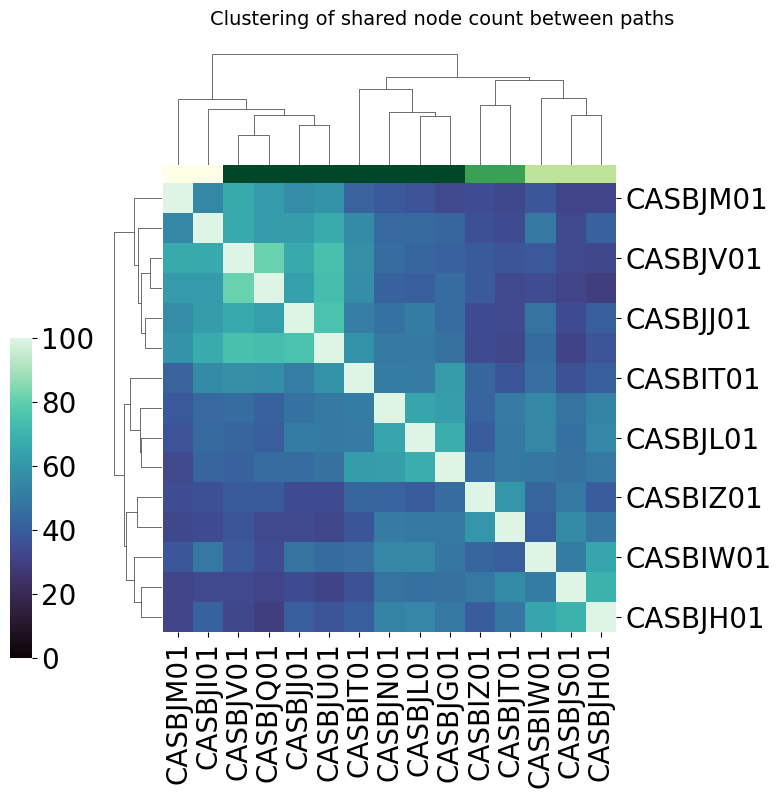

In [40]:
node_share_clustering:list[list] = [
    [
        len(set([x for (x,_) in cactus_gfa.paths[xpath]['path']]).intersection(set([x for (x,_) in cactus_gfa.paths[ypath]['path']])))/len(set([x for (x,_) in cactus_gfa.paths[xpath]['path']]).union(set([x for (x,_) in cactus_gfa.paths[ypath]['path']])))*100 for ypath in graph_paths
    ] for xpath in graph_paths
]
row_colors = get_palette_from_list([int(color_list['leaves_color_list'][color_list['ivl'].index(l)][1]) for l in graph_paths],cmap_name='YlGn')

df_clustering = DataFrame(node_share_clustering, graph_paths, graph_paths) 

ax = clustermap(
    df_clustering,
    figsize=(7.2, 8),
    cmap="mako",
    vmin=0,
    vmax=100,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(-0.1, .2, .03, .4),
    col_colors=row_colors,
)
ax.figure.suptitle('Clustering of shared node count between paths',y=1.01, fontsize = 14)
plt.savefig("figures/clustering_shared_counts.png", bbox_inches='tight')

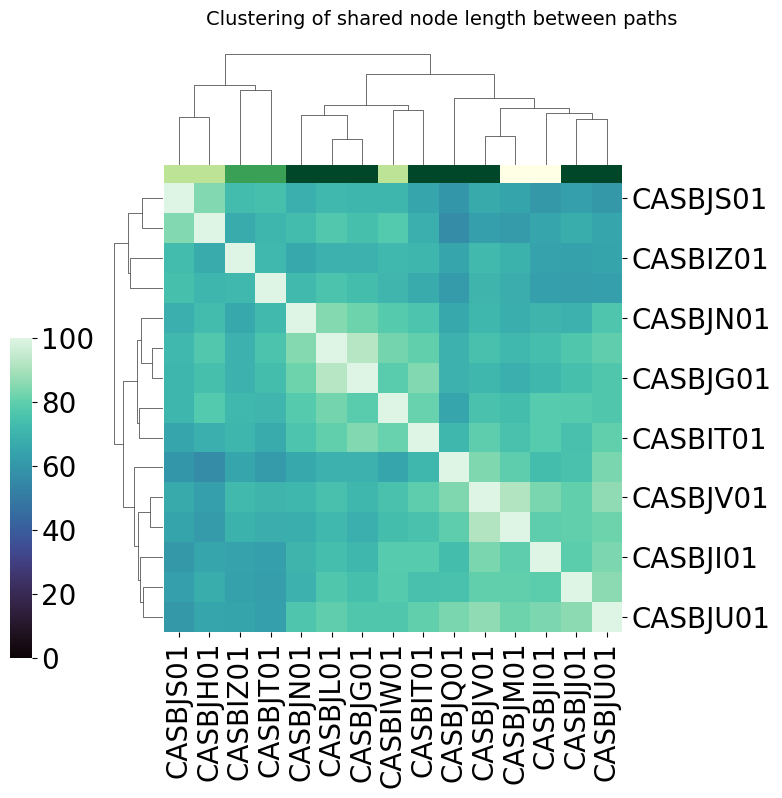

In [41]:
node_share_clustering:list[list] = [
    [
        sum([cactus_gfa.segments[y]['length'] for y in set([x for (x,_) in cactus_gfa.paths[xpath]['path']]).intersection(set([x for (x,_) in cactus_gfa.paths[ypath]['path']]))])/sum([cactus_gfa.segments[y]['length'] for y in set([x for (x,_) in cactus_gfa.paths[xpath]['path']]).union(set([x for (x,_) in cactus_gfa.paths[ypath]['path']]))])*100 for ypath in graph_paths
    ] for xpath in graph_paths
]
row_colors = get_palette_from_list([int(color_list['leaves_color_list'][color_list['ivl'].index(l)][1]) for l in graph_paths],cmap_name='YlGn')

df_clustering = DataFrame(node_share_clustering, graph_paths, graph_paths) 

ax = clustermap(
    df_clustering,
    figsize=(7.2, 8),
    cmap="mako",
    vmin=0,
    vmax=100,

    dendrogram_ratio=(.1, .2),
    cbar_pos=(-0.1, .2, .03, .4),
    col_colors=row_colors,
)
ax.figure.suptitle('Clustering of shared node length between paths',y=1.01, fontsize = 14)
plt.savefig("figures/clustering_shared_lengths.png", bbox_inches='tight')

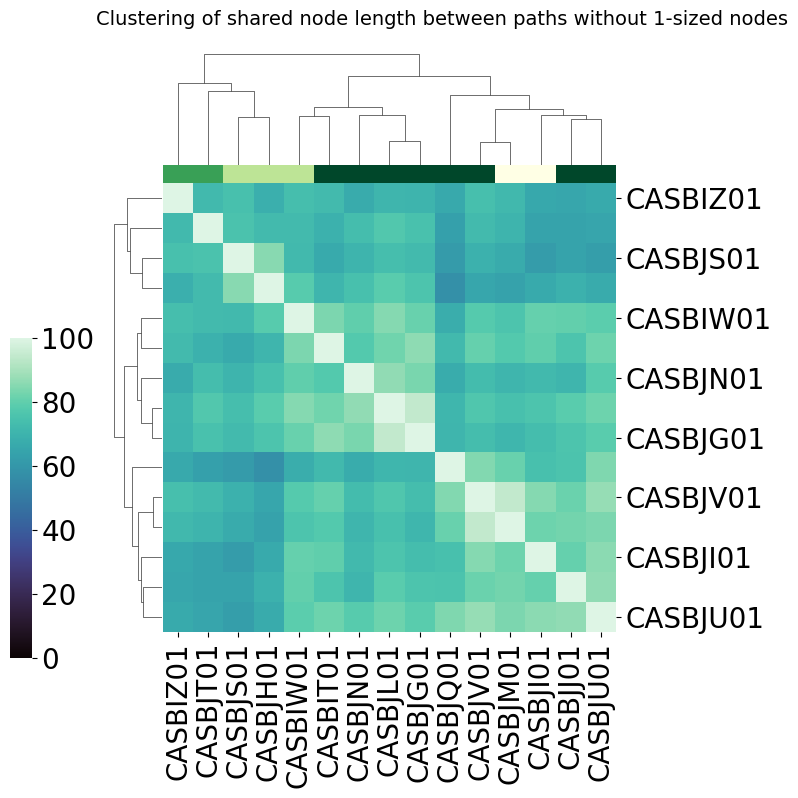

In [42]:
path_minus_1_sized:dict[str,list] = {
    path_name:[x for (x,_) in cactus_gfa.paths[path_name]['path'] if cactus_gfa.segments[x]['length'] > 1] for path_name in graph_paths
}

node_share_clustering:list[list] = [
    [
        sum([cactus_gfa.segments[y]['length'] for y in set(path_minus_1_sized[xpath]).intersection(set(path_minus_1_sized[ypath]))])/sum([cactus_gfa.segments[y]['length'] for y in set(path_minus_1_sized[xpath]).union(set(path_minus_1_sized[ypath]))])*100 for ypath in graph_paths
    ] for xpath in graph_paths
]
row_colors = get_palette_from_list([int(color_list['leaves_color_list'][color_list['ivl'].index(l)][1]) for l in graph_paths],cmap_name='YlGn')

df_clustering = DataFrame(node_share_clustering, graph_paths, graph_paths) 

ax = clustermap(
    df_clustering,
    figsize=(7.2, 8),
    cmap="mako",
    vmin=0,
    vmax=100,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(-0.1, .2, .03, .4),
    col_colors=row_colors,
)
ax.figure.suptitle('Clustering of shared node length between paths without 1-sized nodes',y=1.01, fontsize = 14)
plt.savefig("figures/clustering_shared_no_outliers.png", bbox_inches='tight')

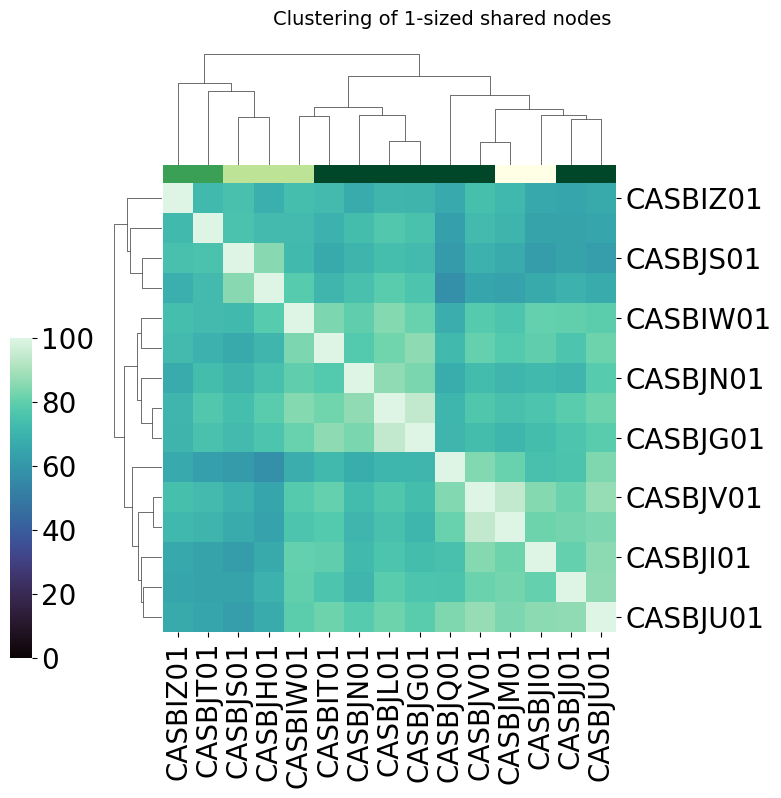

In [43]:
path_1_sized:dict[str,list] = {
    path_name:[x for (x,_) in cactus_gfa.paths[path_name]['path'] if cactus_gfa.segments[x]['length'] == 1] for path_name in graph_paths
}

node_share_clustering:list[list] = [
    [
        sum([cactus_gfa.segments[y]['length'] for y in set(path_minus_1_sized[xpath]).intersection(set(path_minus_1_sized[ypath]))])/sum([cactus_gfa.segments[y]['length'] for y in set(path_minus_1_sized[xpath]).union(set(path_minus_1_sized[ypath]))])*100 for ypath in graph_paths
    ] for xpath in graph_paths
]
row_colors = get_palette_from_list([int(color_list['leaves_color_list'][color_list['ivl'].index(l)][1]) for l in graph_paths],cmap_name='YlGn')

df_clustering = DataFrame(node_share_clustering, graph_paths, graph_paths) 

ax = clustermap(
    df_clustering,
    figsize=(7.2, 8),
    cmap="mako",
    vmin=0,
    vmax=100,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(-0.1, .2, .03, .4),
    col_colors=row_colors,
)
ax.figure.suptitle('Clustering of 1-sized shared nodes',y=1.01, fontsize = 14)
plt.savefig("figures/clustering_one_sized.png", bbox_inches='tight')

### Distribution des variants

Devrait normalement suivre les distributions des noeuds

### Corrélation entre distance mash à la référence et nombre de noeuds

- ou sinon clustering par rapport au nombre de noeuds

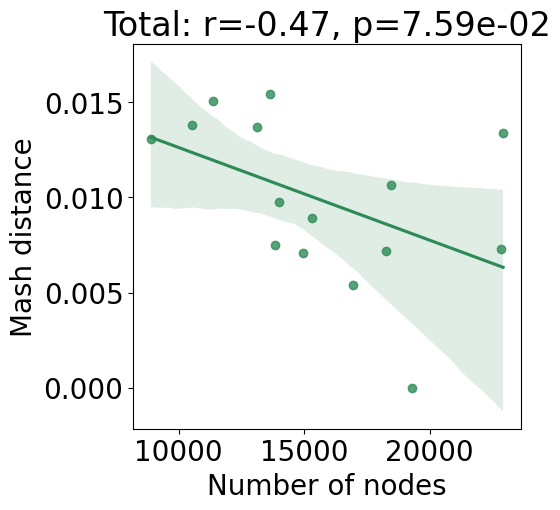

In [44]:
# il faut une valeur de distance aux autres ou utiliser les distances à la ref ?
reference:str = 'CASBJU01'


path_lengths:dict[str,int] = {
    path_name:len(cactus_gfa.paths[path_name]['path']) for path_name in graph_paths
}

mash_dist:dict[str,float] = {
    path_name:mash[graph_paths.index(reference)][graph_paths.index(path_name)] for path_name in graph_paths
}

fig, ax = plt.subplots(figsize=(5,5))

df_ve = DataFrame([[path_lengths[path_name] for path_name in graph_paths],[mash_dist[path_name] for path_name in graph_paths]],['path_length','mash_dist'])
df_ve = df_ve.transpose()

ax.set_title(f"Total: r={round(stats.pearsonr(df_ve['path_length'], df_ve['mash_dist'])[0],2)}, p={stats.pearsonr(df_ve['path_length'], df_ve['mash_dist'])[1]:.2e}")
regplot(x='path_length', y='mash_dist', data=df_ve, ax=ax, color='seagreen')
ax.set_ylabel('Mash distance')
ax.set_xlabel('Number of nodes')

plt.savefig("figures/corellogram_mash_shared_node.png", bbox_inches='tight')

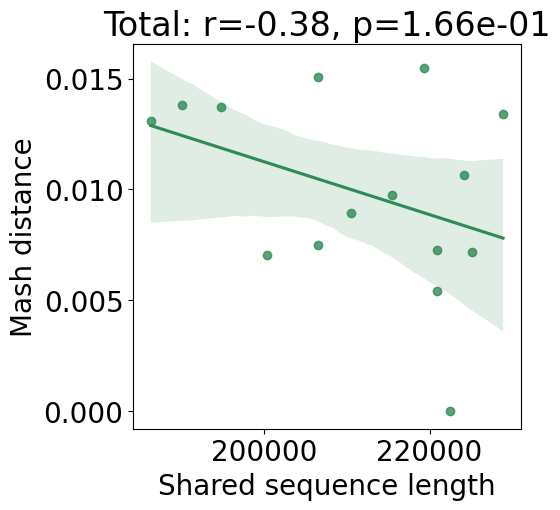

In [45]:
# il faut une valeur de distance aux autres ou utiliser les distances à la ref ?
reference:str = 'CASBJU01'


path_lengths:dict[str,int] = {
    path_name:sum([cactus_gfa.segments[x]['length'] for x,_ in cactus_gfa.paths[path_name]['path']]) for path_name in graph_paths
}

mash_dist:dict[str,float] = {
    path_name:mash[graph_paths.index(reference)][graph_paths.index(path_name)] for path_name in graph_paths
}

fig, ax = plt.subplots(figsize=(5,5))

df_ve = DataFrame([[path_lengths[path_name] for path_name in graph_paths],[mash_dist[path_name] for path_name in graph_paths]],['path_length','mash_dist'])
df_ve = df_ve.transpose()

ax.set_title(f"Total: r={round(stats.pearsonr(df_ve['path_length'], df_ve['mash_dist'])[0],2)}, p={stats.pearsonr(df_ve['path_length'], df_ve['mash_dist'])[1]:.2e}")
regplot(x='path_length', y='mash_dist', data=df_ve, ax=ax, color='seagreen')
ax.set_ylabel('Mash distance')
ax.set_xlabel('Shared sequence length')
plt.savefig("figures/corellogram_mash_shared_length.png", bbox_inches='tight')
